# Simple CNN with MNIST

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

mnist = input_data.read_data_sets('/Basic TF & thing/mnist/', one_hot=True)

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Extracting /Basic TF & thing/mnist/train-images-idx3-ubyte.gz
Extracting /Basic TF & thing/mnist/train-labels-idx1-ubyte.gz
Extracting /Basic TF & thing/mnist/t10k-images-idx3-ubyte.gz
Extracting /Basic TF & thing/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
a = mnist.train.labels.shape
a

(55000, 10)

# Select GPU to be used

In [2]:
device_type = '/gpu:0'

# Define Params and Network Params

In [6]:
#Params
learning_rate = 0.001
epochs = 10
batch_size = 100
display_step = 5

#Define Network params, weights and biases
with tf.device(device_type): # <-- This is optional
    n_input = 784                            #input features (imageshape 28*28)
    n_classes = mnist.train.labels.shape[1]  #number of output ditgits 0 -> 9
    
    weights = {
        'w1': tf.Variable(tf.random_normal(shape=[3,3,1,64], stddev = 0.1)),
        'wd1': tf.Variable(tf.random_normal(shape=[14*14*64, n_classes], stddev= 0.1))
    }
    
    biases = {
        'b1': tf.Variable(tf.random_normal(shape=[64], stddev= 0.1)),
        'bd1': tf.Variable(tf.random_normal(shape=[n_classes], stddev= 0.1))
    }

#Define placeholder
x = tf.placeholder(dtype=tf.float32, shape=[None, n_input])
y = tf.placeholder(dtype=tf.float32, shape=[None, n_classes])

# Define convolutional function

In [11]:
with tf.device(device_type): # <-- This is optional
    def conv_simple(x, weights, biases):
        #Reshape input first
        input_r = tf.reshape(tensor=x, shape=[-1,28,28,1])
        #Convolution layer 1
        conv1 = tf.nn.conv2d(input_r, weights['w1'], strides=[1,1,1,1], padding='SAME')
        conv2 = tf.nn.bias_add(conv1, biases['b1'])
        conv3 = tf.nn.relu(conv2)
        maxpool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        #Vectorize
        dense = tf.reshape(maxpool, shape=[-1, weights['wd1'].get_shape().as_list()[0]])
        
        #Fully connected layer
        out = tf.add(tf.matmul(dense, weights['wd1']), biases['bd1'])
        
        #Return every layer
        out = {
            'input_r': input_r, 'conv1': conv1, 'conv2': conv2, 'conv3': conv3, 'maxpool': maxpool, 'dense': dense, 'out': out
        }
        
        return out

# Define other function computation graph

In [12]:
with tf.device(device_type): # <-- This is optional
    y_pred = conv_simple(x, weights, biases)['out']
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))
    
    init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



# Save the model for later uses

In [13]:
#Saver
save_step = 1
# savedir = 'saved_models/'
saver = tf.train.Saver(max_to_keep=3)

# Training Phase

In [14]:
#Do train or NOT
do_train = 1
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

In [15]:
if do_train == 1:
    for epoch in range(epochs):
        avg_loss = 0
        total_batch = int(mnist.train.num_examples / batch_size)
        
        #Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            
            #Fit training using batch data
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            
            #Compute avg loss
            avg_loss += sess.run(loss, feed_dict={x: batch_x, y: batch_y}) / total_batch
            
        #Display logs per epoch
        if epoch % display_step == 0:
            print('Epoch %03d/%03d,    loss= %.4f' % (epoch, epochs, avg_loss))
            train_accuracy = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            test_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})
            print('-->    Training accuracy = %.4f' % train_accuracy)
            print('-->    Test accuracy = %.4f' % test_accuracy)
            
        #Save model
        if epoch % save_step == 0:
            saver.save(sess, 'saved_models/cnn_mnist_simple.ckpt-' + str(epoch))

Epoch 000/010,    loss= 0.3044
-->    Training accuracy = 0.9700
-->    Test accuracy = 0.9654
Epoch 005/010,    loss= 0.0413
-->    Training accuracy = 1.0000
-->    Test accuracy = 0.9813


# Restore model from saver

In [16]:
if do_train == 0:
    epoch = epochs - 1
    saver.restore(sess, 'saved_models/cnn_mnist_simple.ckpt-' + str(epoch))

# Let's see how CNN works and inside each layer

In [17]:
with tf.device(device_type): # <-- This is optional
    conv_out = conv_simple(x, weights, biases)
    
input_r = sess.run(conv_out['input_r'], feed_dict={x: mnist.train.images[0:1, :]})
conv1 = sess.run(conv_out['conv1'], feed_dict={x: mnist.train.images[0:1, :]})
conv2 = sess.run(conv_out['conv2'], feed_dict={x: mnist.train.images[0:1, :]})
conv3 = sess.run(conv_out['conv3'], feed_dict={x: mnist.train.images[0:1, :]})
maxpool = sess.run(conv_out['maxpool'], feed_dict={x: mnist.train.images[0:1, :]})
dense = sess.run(conv_out['dense'], feed_dict={x: mnist.train.images[0:1, :]})
out = sess.run(conv_out['out'], feed_dict={x: mnist.train.images[0:1, :]})

# Input layer

Size of input_r is (1, 28, 28, 1)
Label is 1


([], <a list of 0 Text yticklabel objects>)

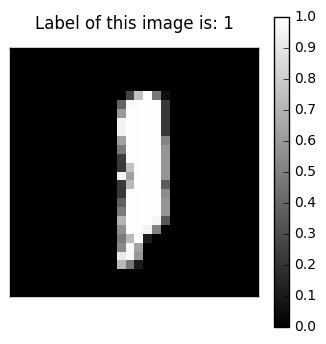

In [24]:
print('Size of input_r is', input_r.shape)
label = np.argmax(mnist.train.labels[0, :])
print('Label is %d' % label)

#Plot
plt.matshow(input_r[0,:,:,0], cmap=plt.get_cmap('gray'))
plt.title('Label of this image is: ' + str(label))
plt.colorbar()
plt.xticks(())
plt.yticks(())

# Conv1 layer

In [28]:
conv1.shape[3]



64

Size of conv1 is (1, 28, 28, 64)


C:\Users\StrikeWade\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


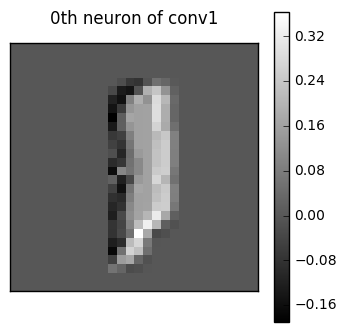

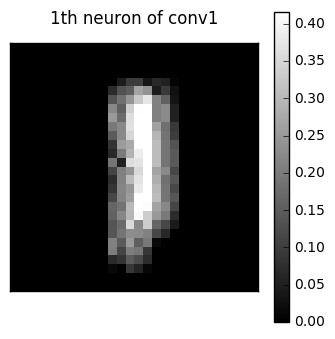

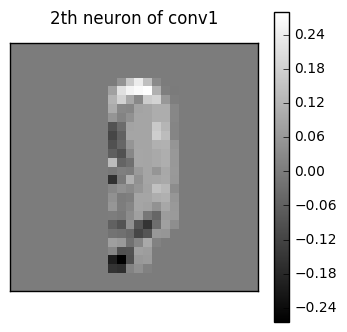

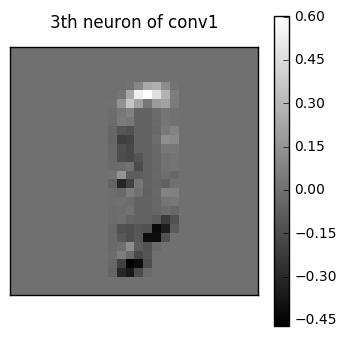

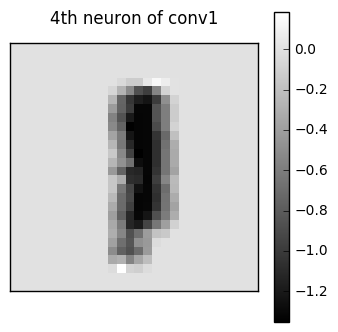

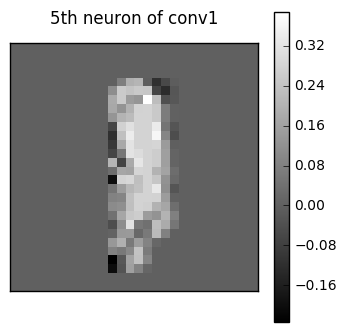

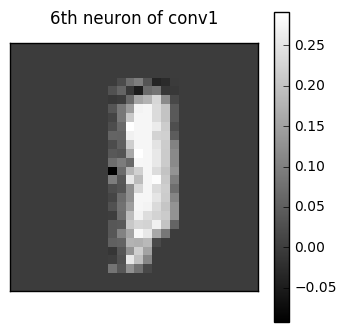

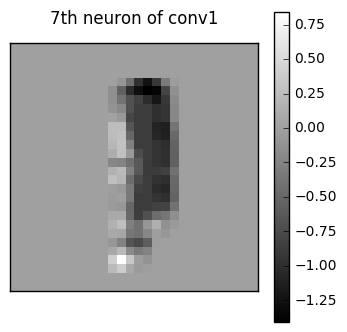

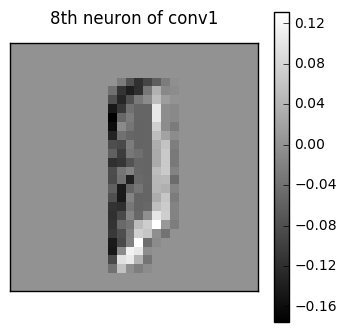

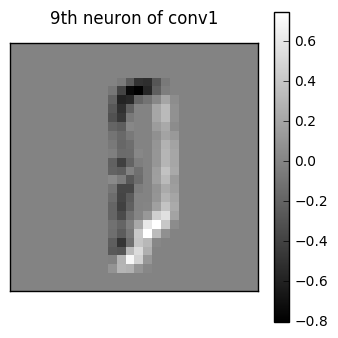

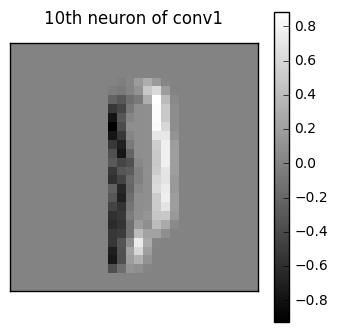

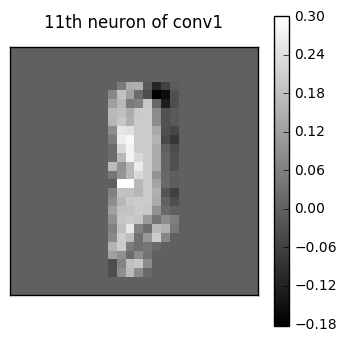

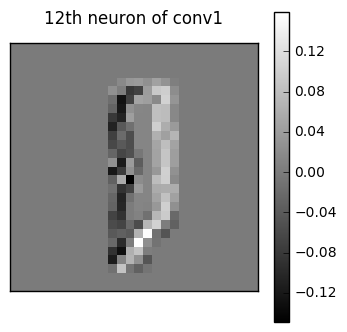

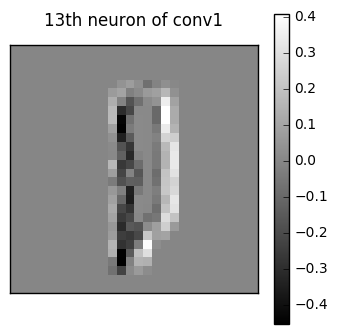

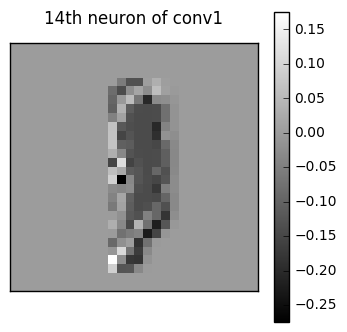

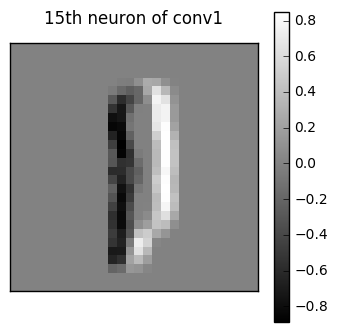

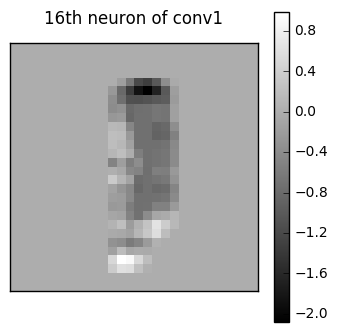

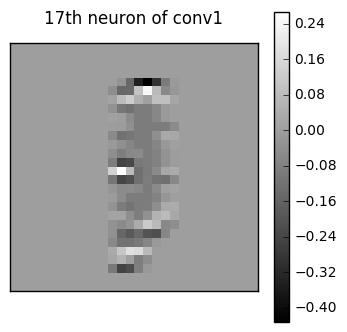

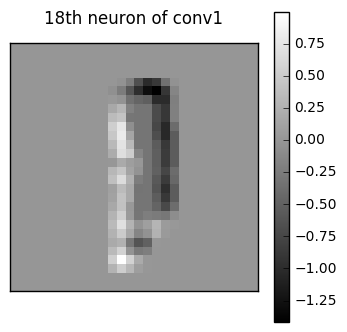

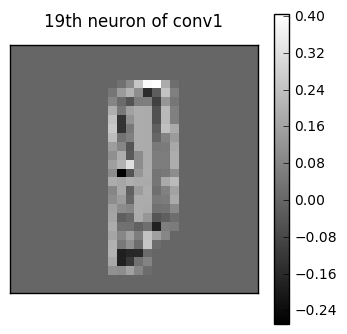

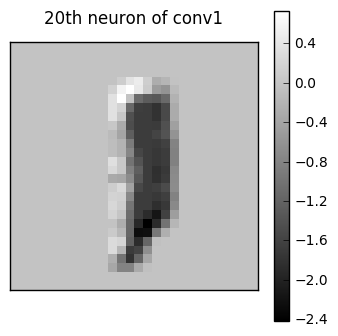

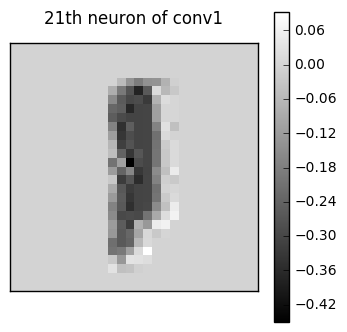

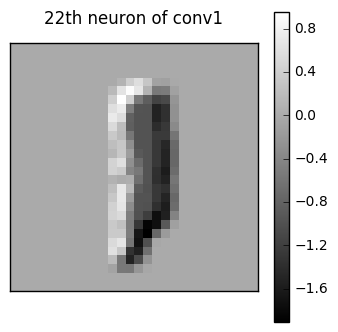

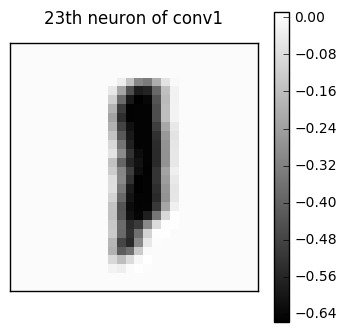

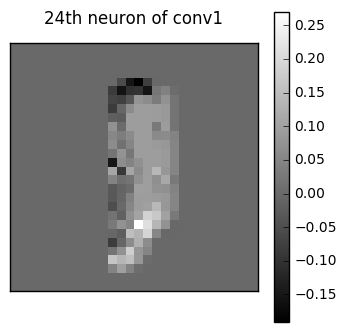

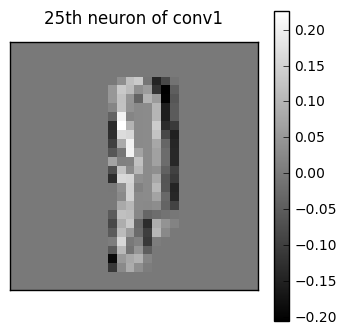

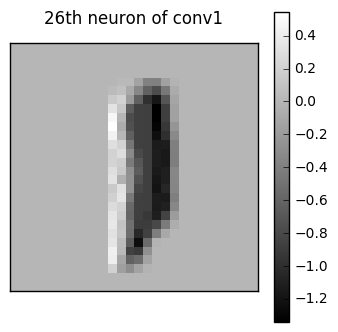

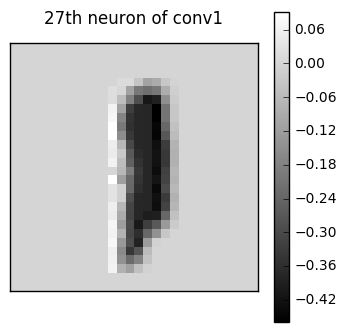

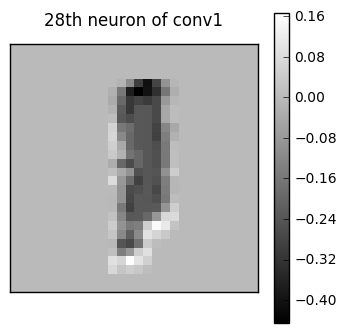

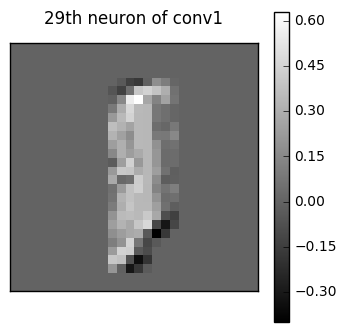

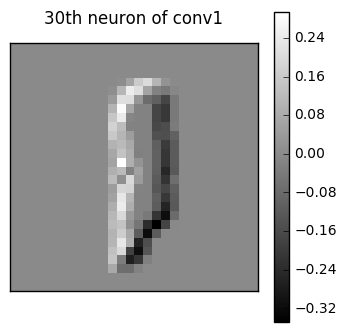

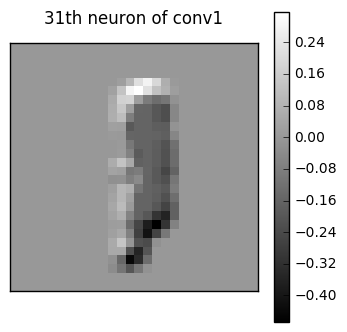

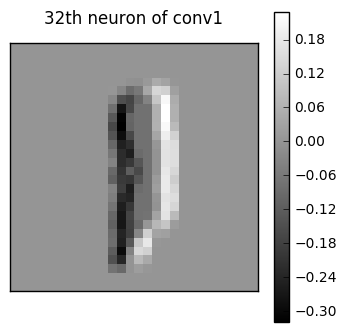

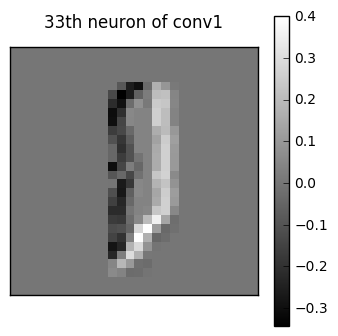

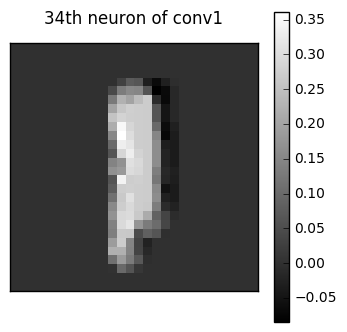

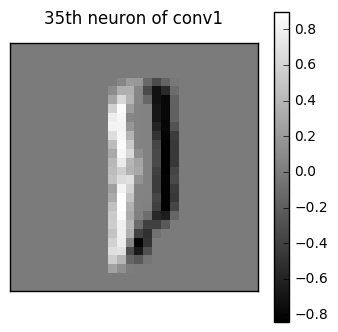

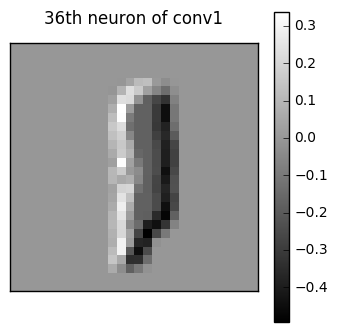

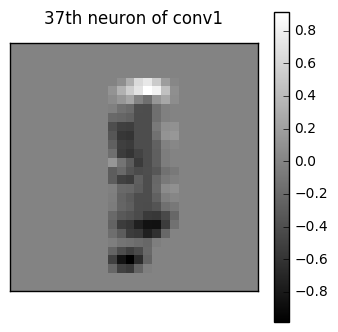

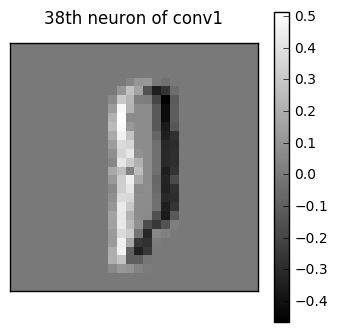

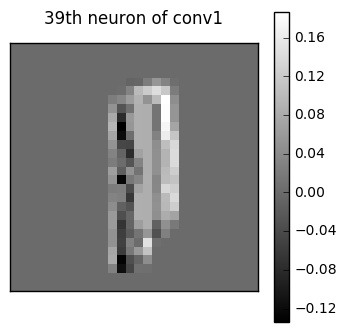

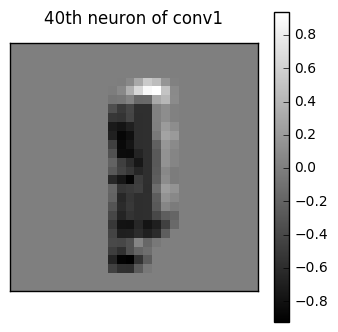

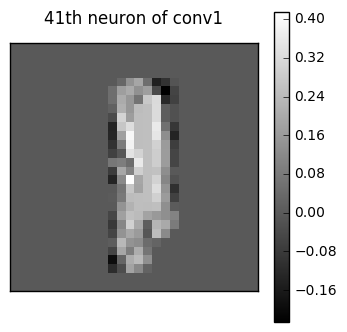

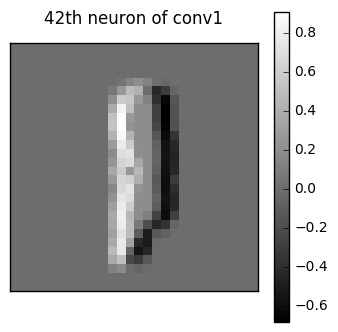

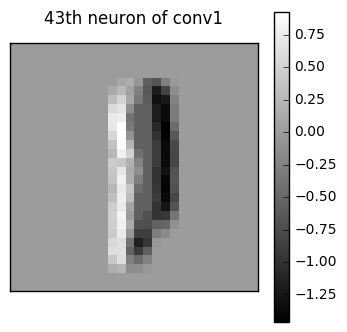

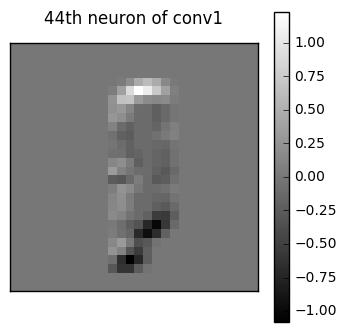

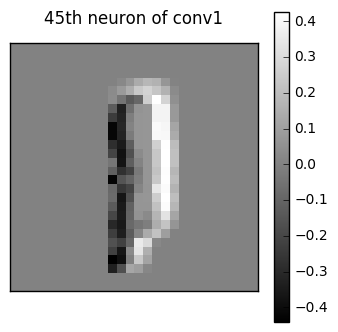

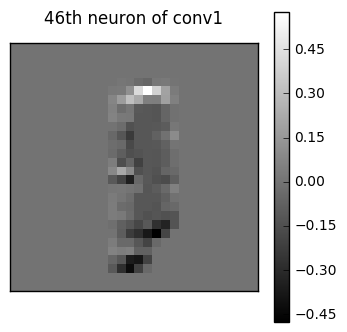

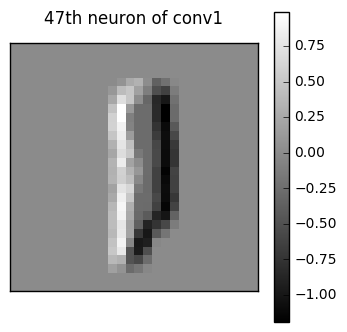

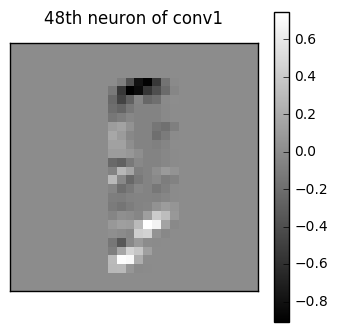

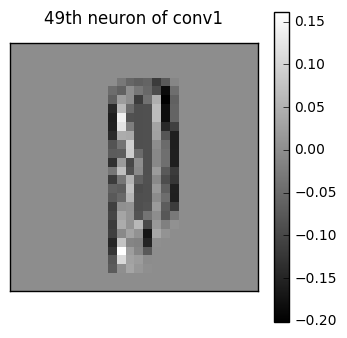

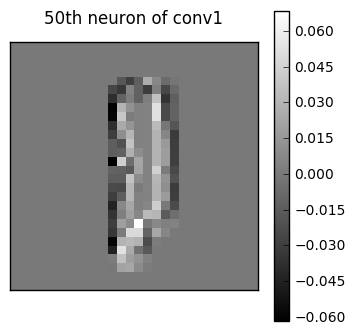

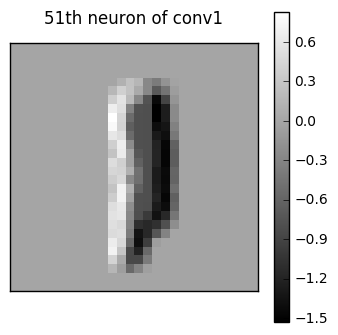

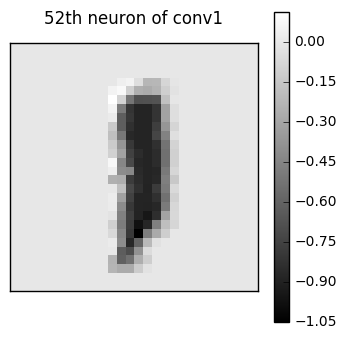

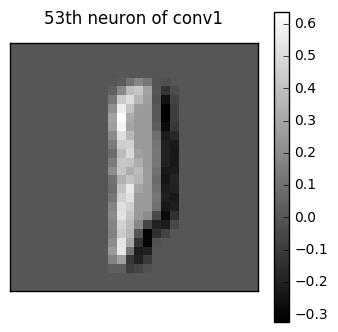

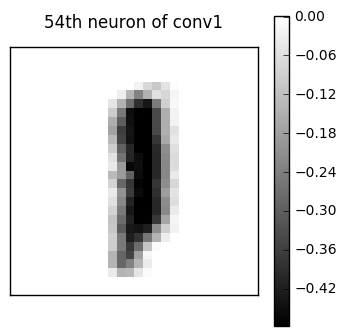

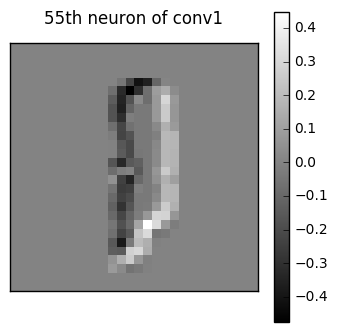

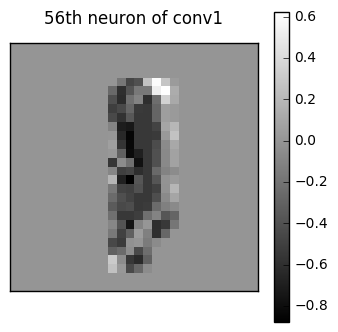

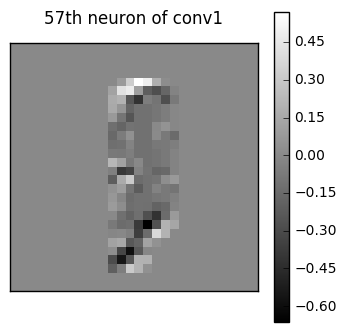

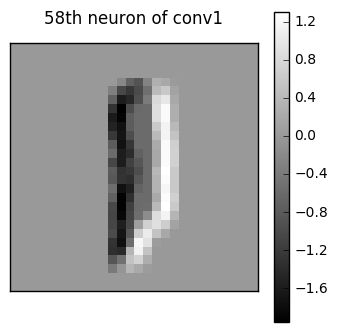

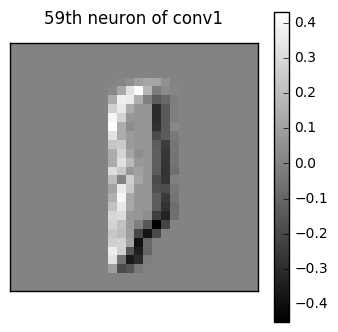

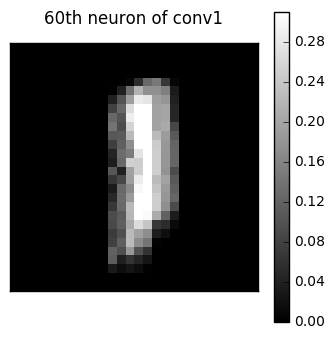

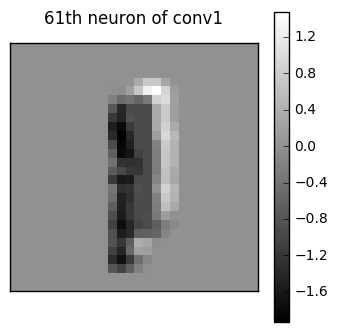

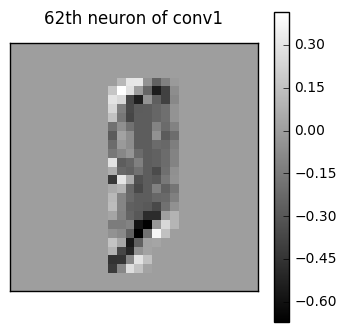

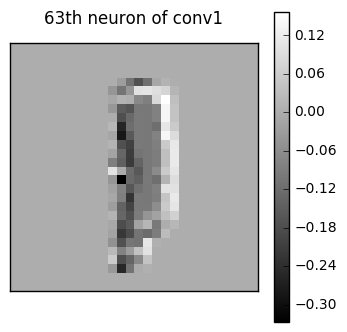

In [35]:
print('Size of conv1 is', conv1.shape)

#Plot
# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20))


# for i, ax in zip(conv1.shape[3], axes.ravel()):
#     ax.matshow(conv1[0,:,:,i], cmap=plt.get_cmap('gray'))
#     ax.set_title(str(i) + 'th neuron')
#     ax.set_xticks(())
#     ax.set_yticks(())

for i in range(conv1.shape[3]):
    plt.matshow(conv1[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th neuron of conv1")
    plt.colorbar()
    plt.xticks(())
    plt.yticks(())

# Conv2 layer (+bias)

Size of conv2 is (1, 28, 28, 64)


C:\Users\StrikeWade\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


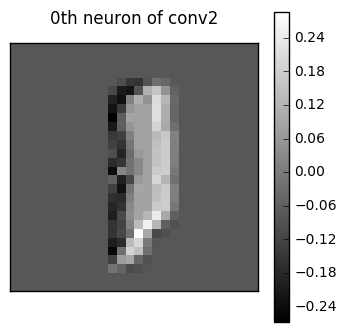

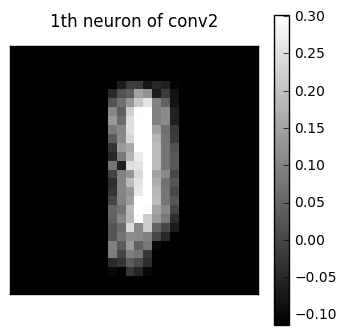

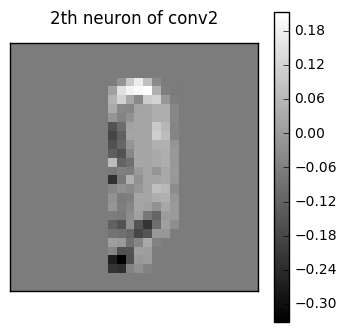

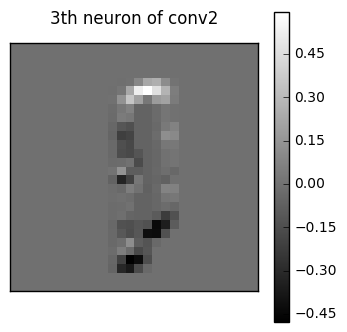

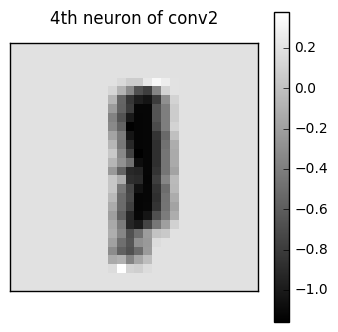

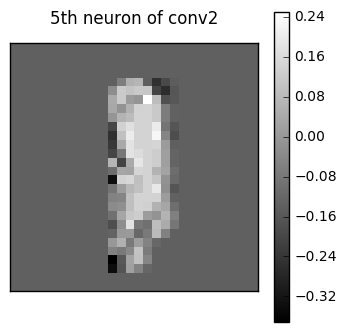

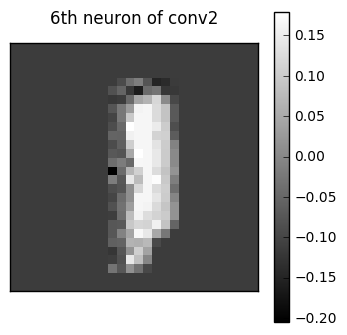

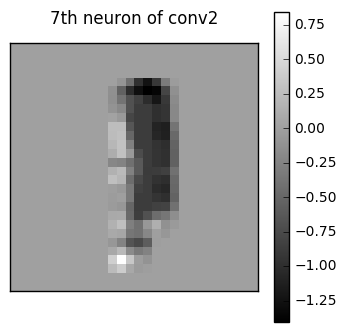

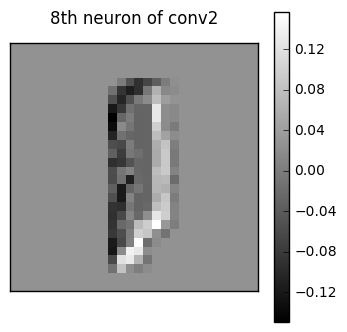

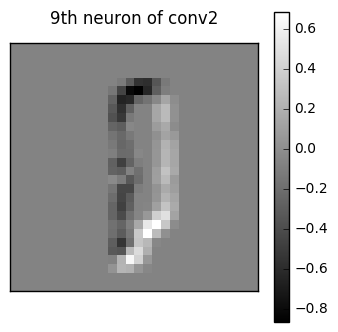

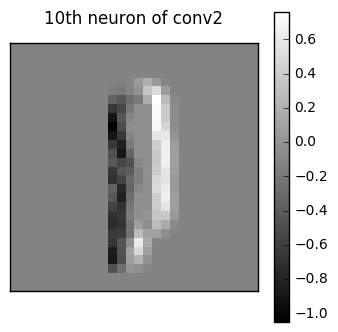

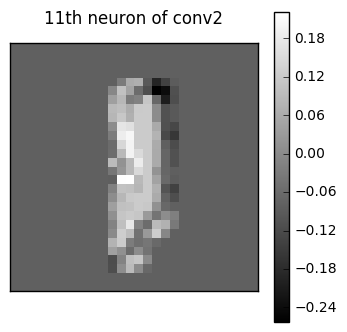

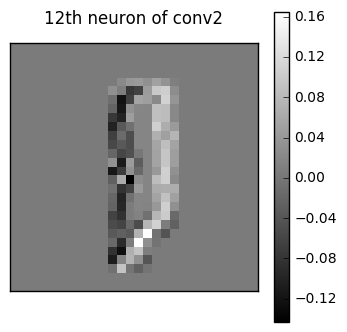

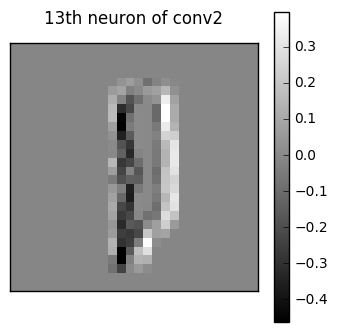

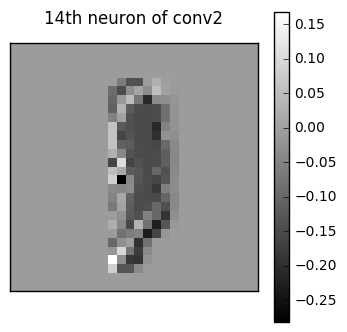

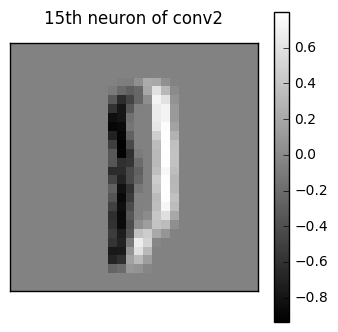

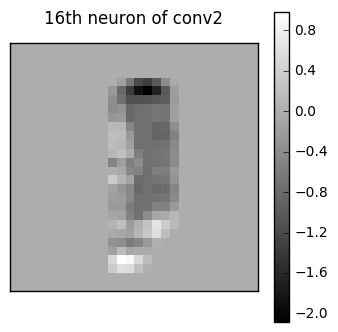

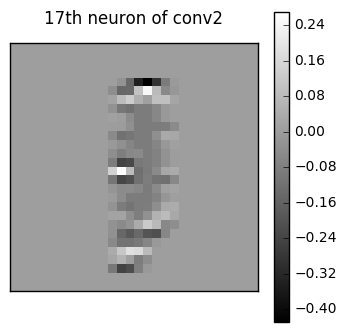

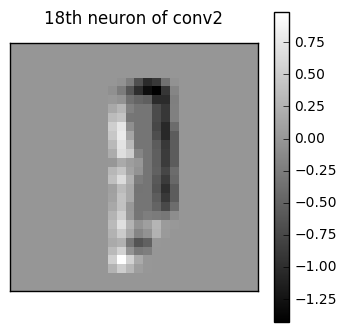

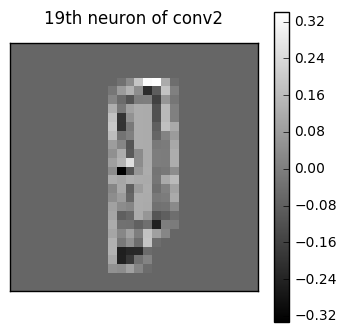

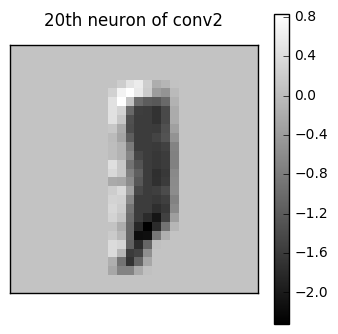

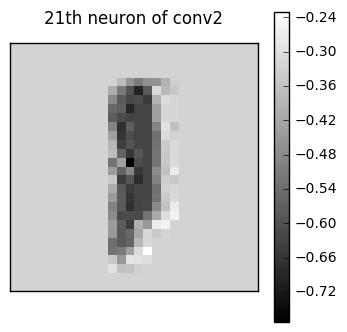

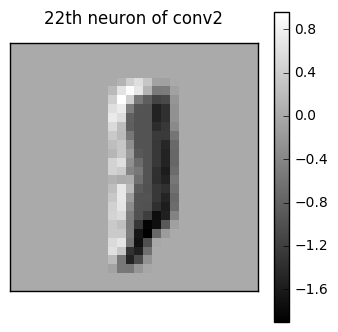

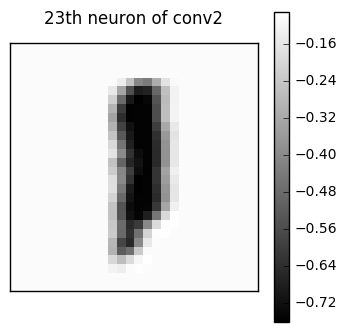

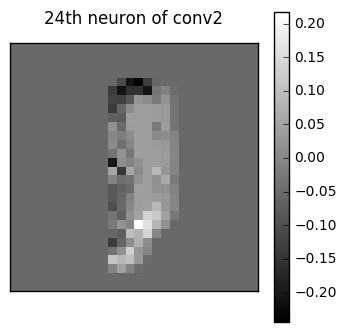

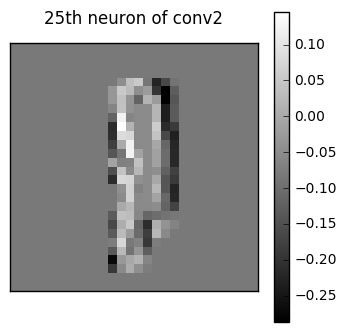

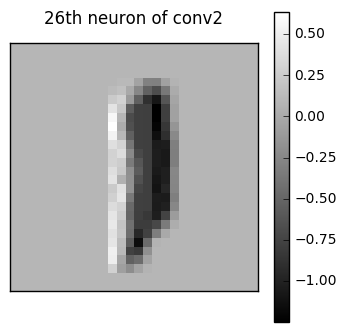

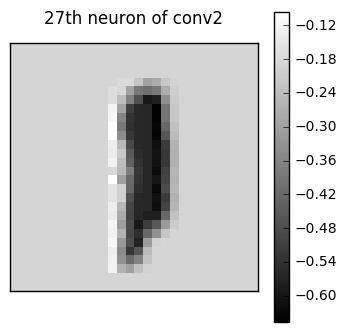

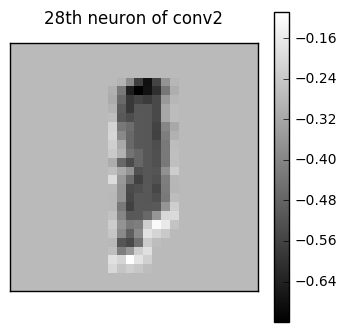

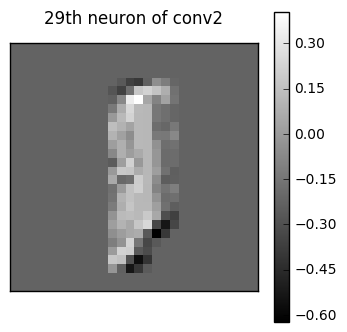

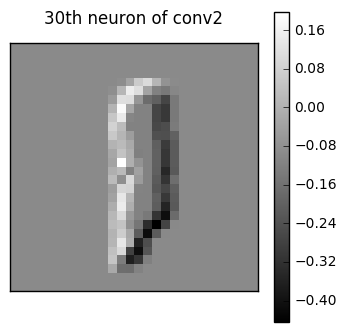

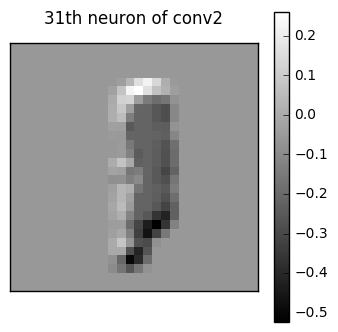

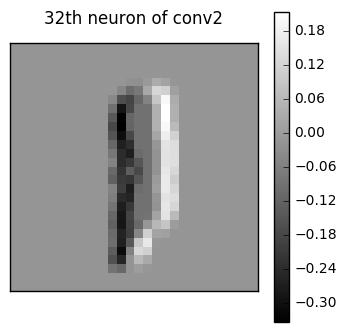

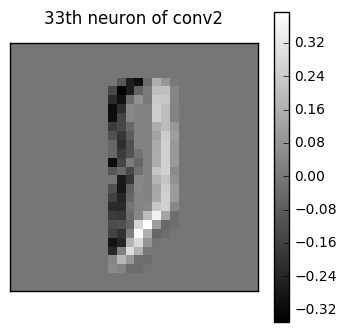

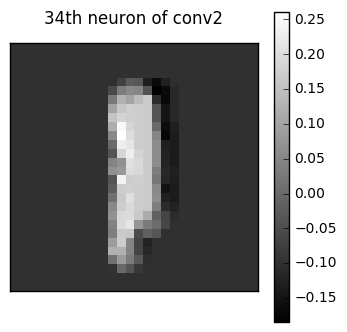

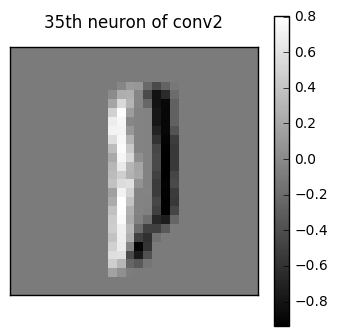

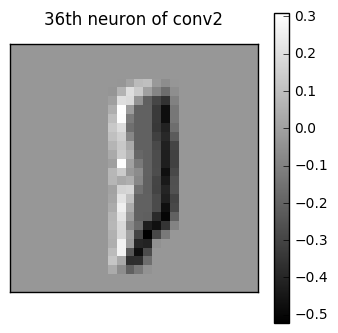

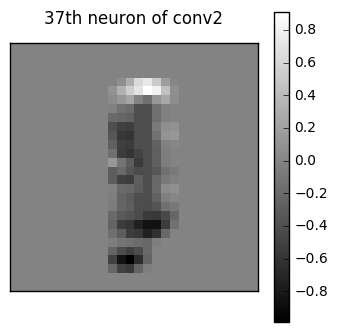

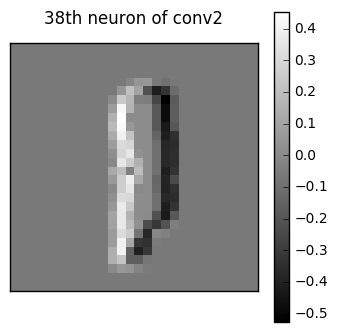

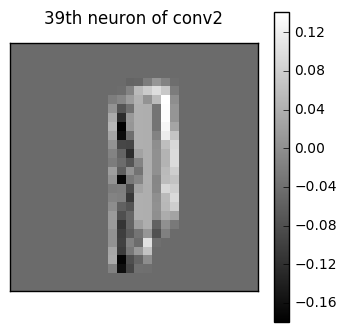

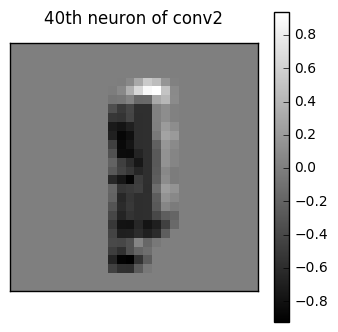

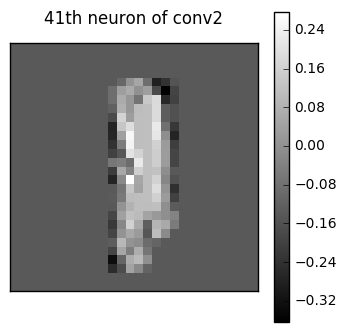

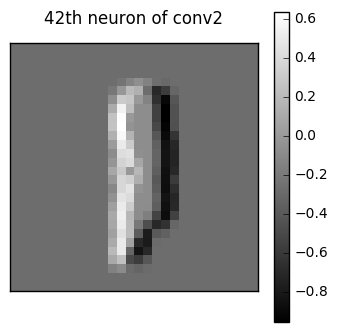

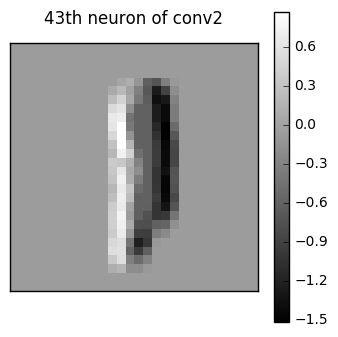

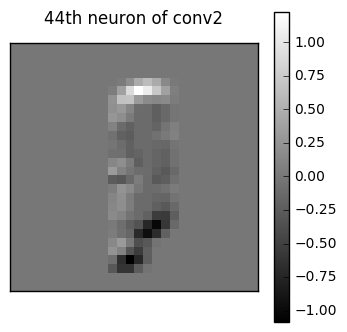

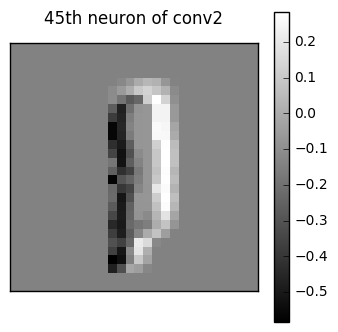

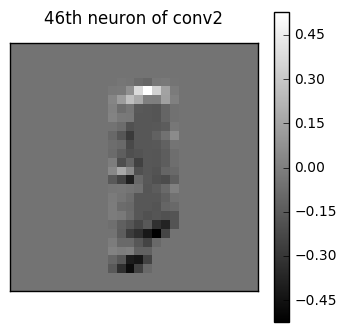

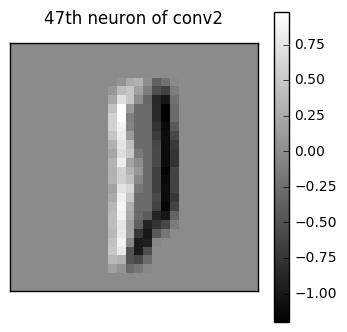

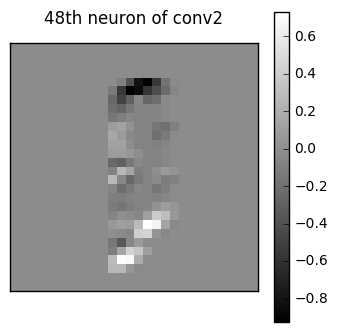

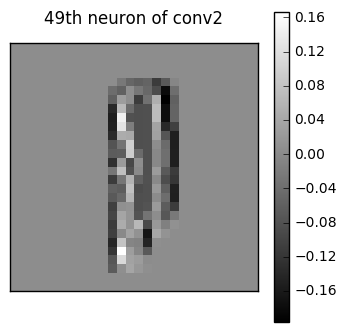

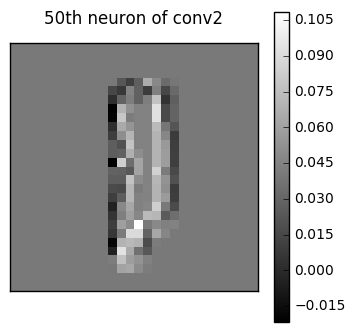

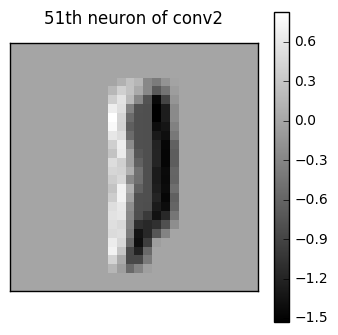

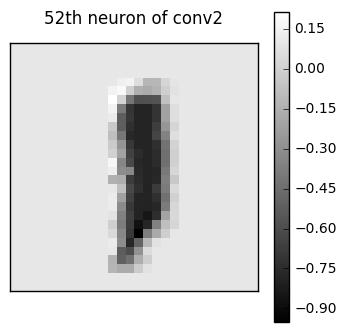

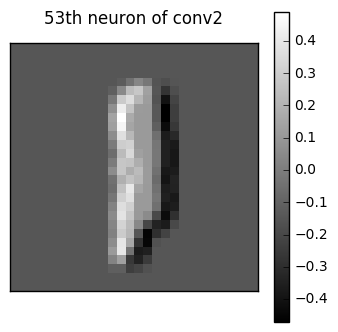

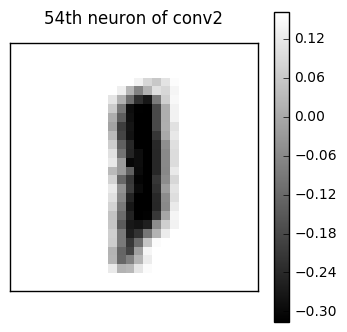

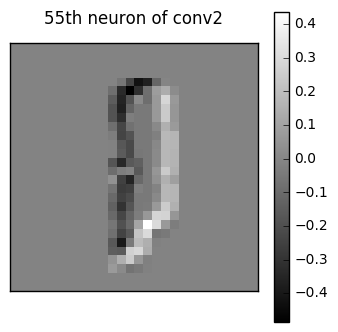

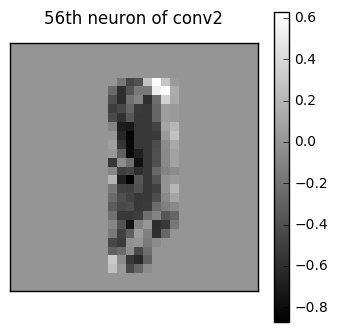

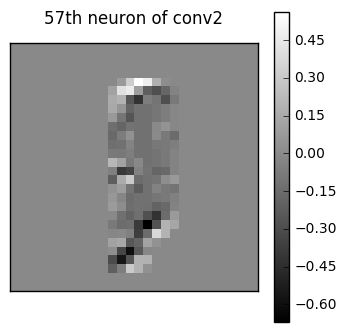

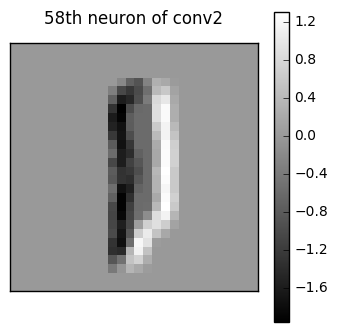

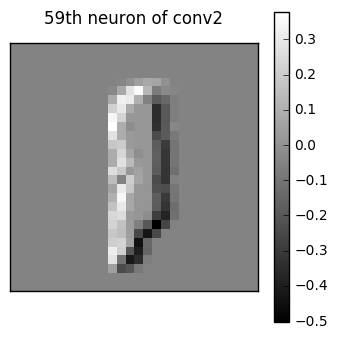

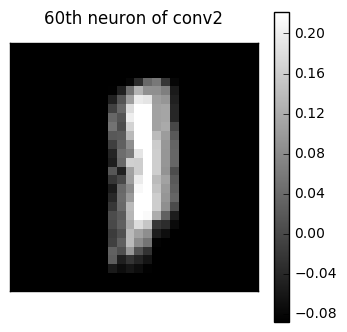

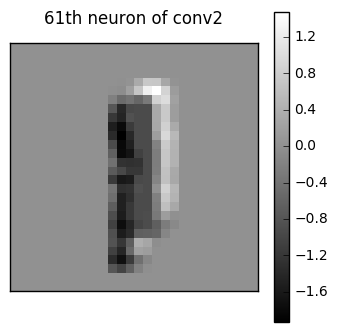

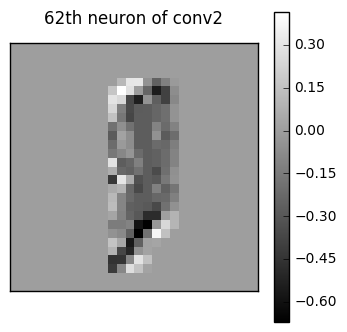

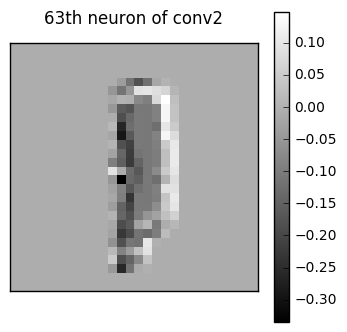

In [37]:
print('Size of conv2 is', conv2.shape)

for i in range(conv2.shape[3]):
    plt.matshow(conv2[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th neuron of conv2")
    plt.colorbar()
    plt.xticks(())
    plt.yticks(())

# Conv3 (relu)

Size of conv3 is (1, 28, 28, 64)


C:\Users\StrikeWade\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


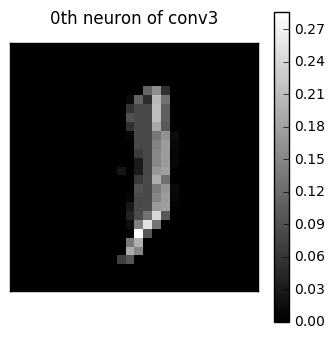

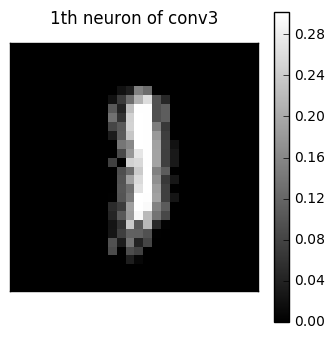

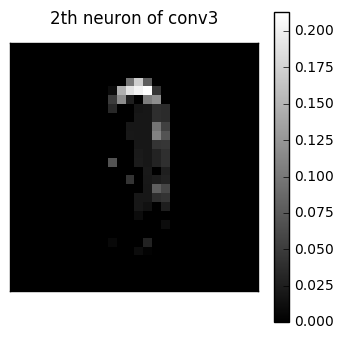

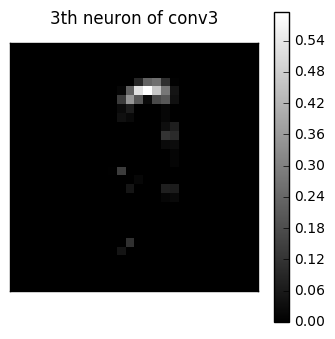

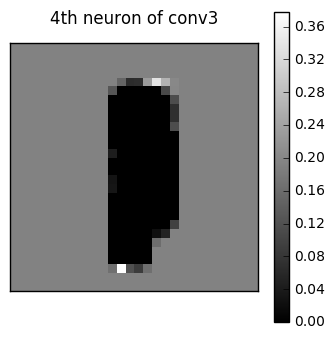

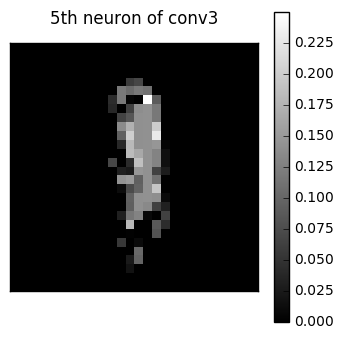

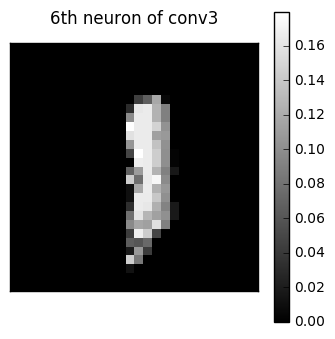

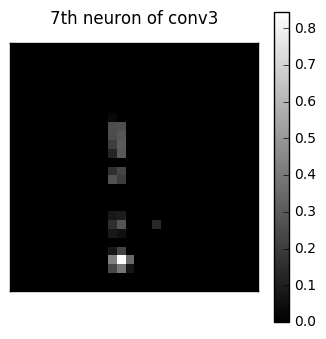

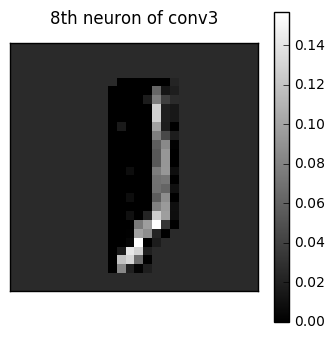

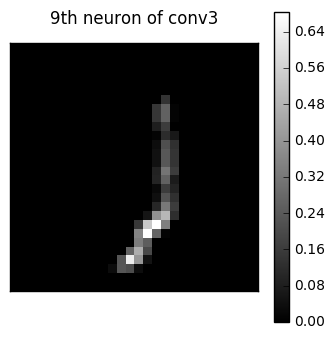

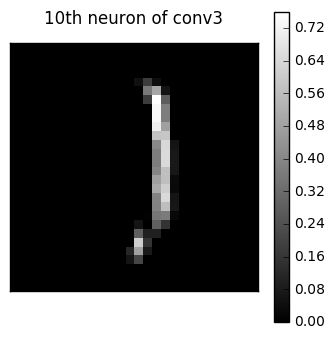

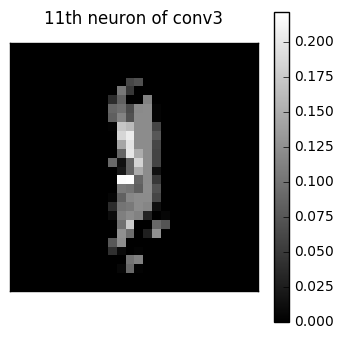

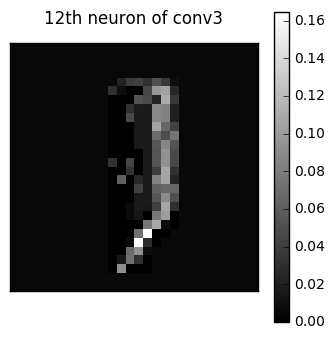

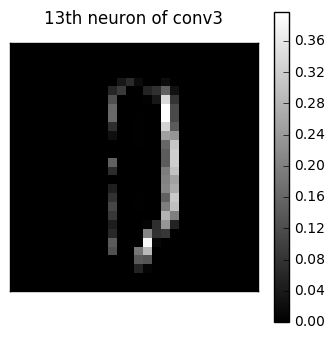

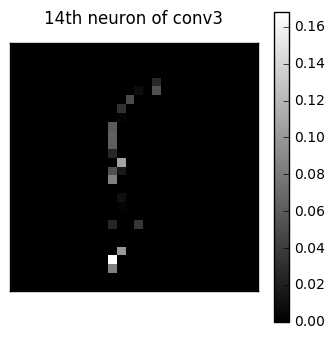

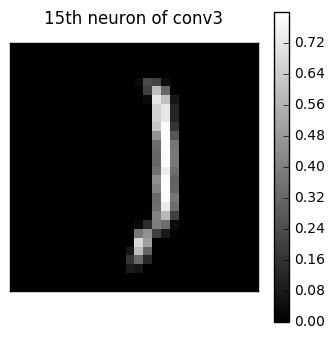

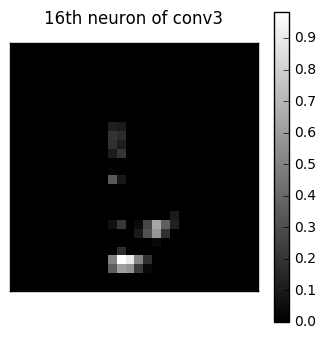

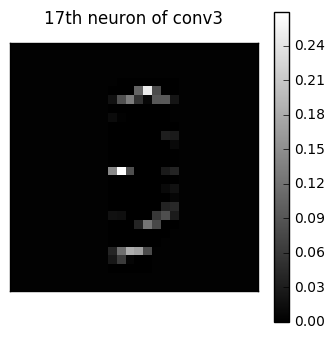

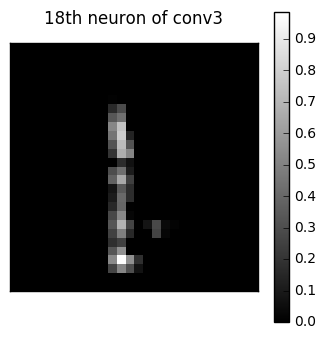

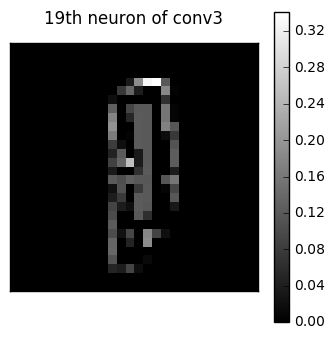

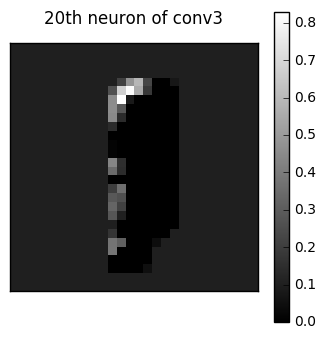

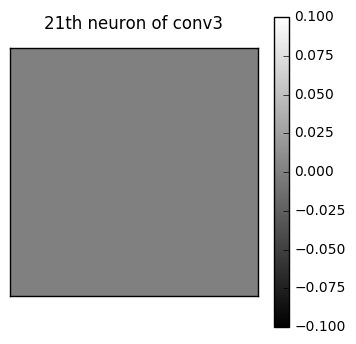

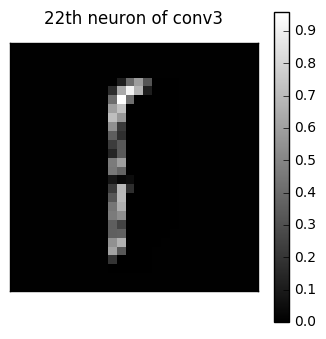

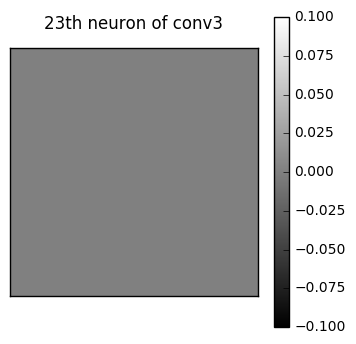

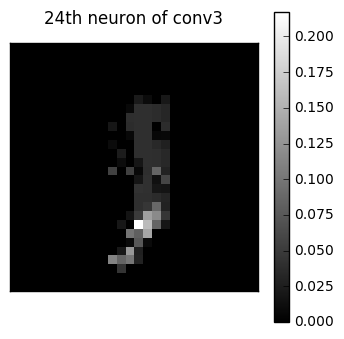

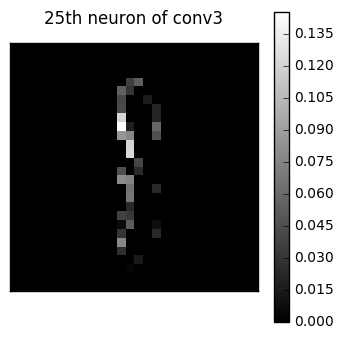

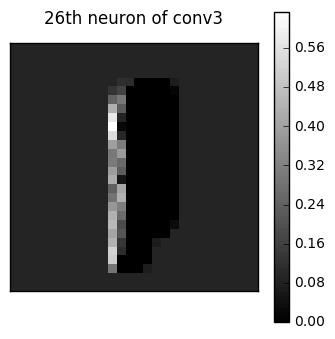

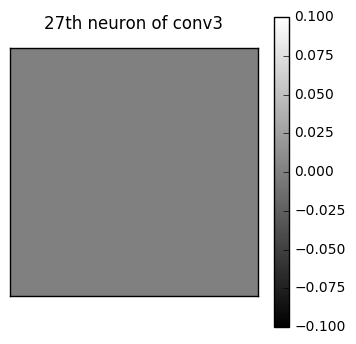

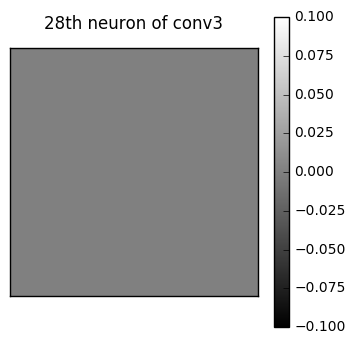

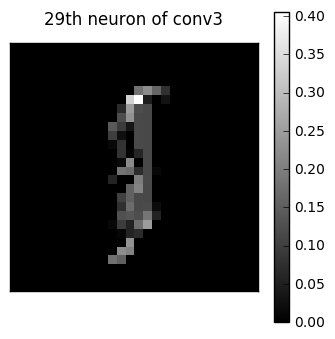

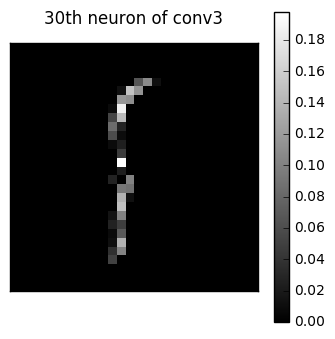

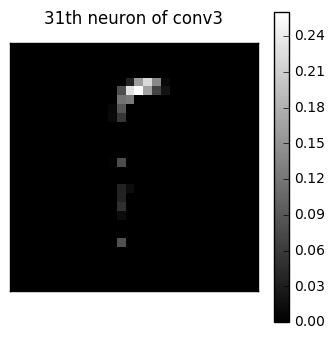

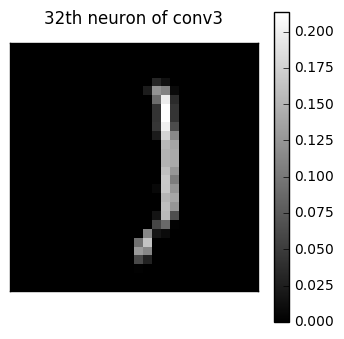

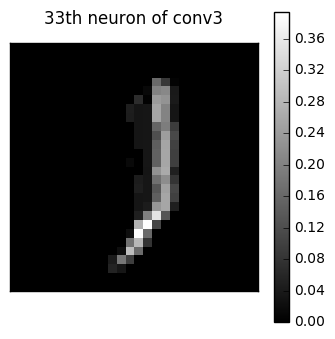

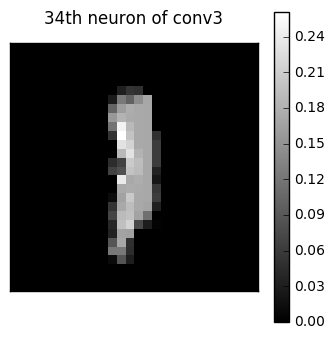

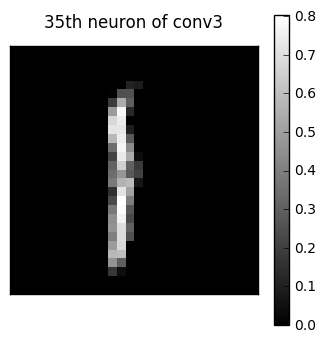

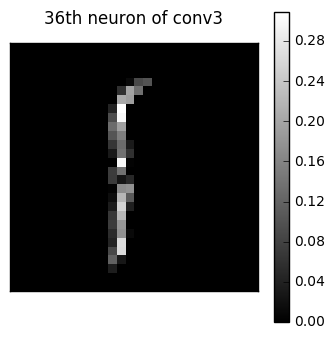

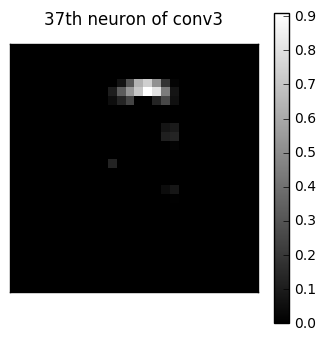

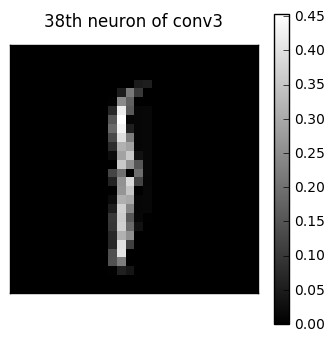

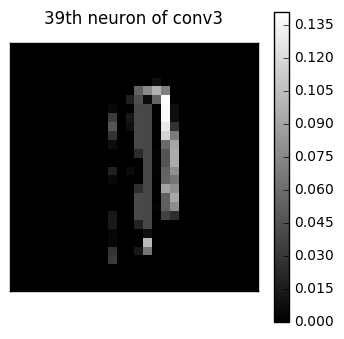

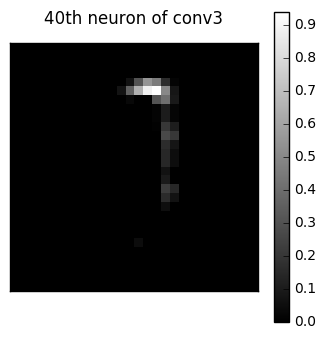

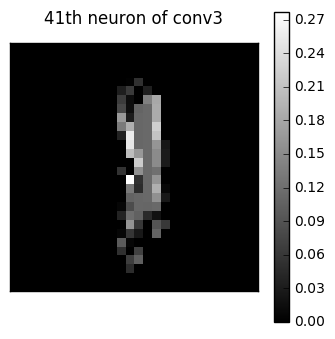

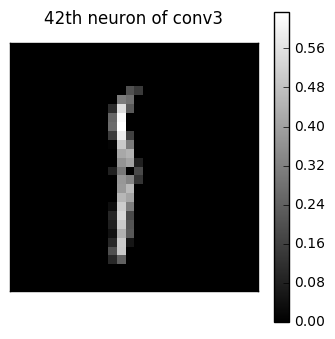

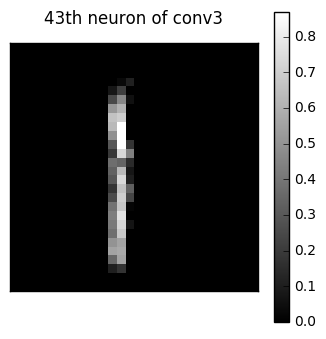

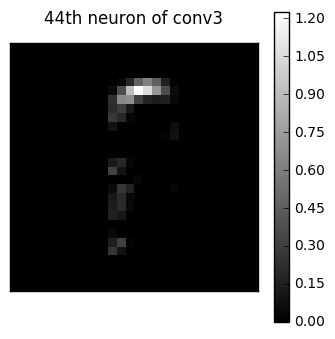

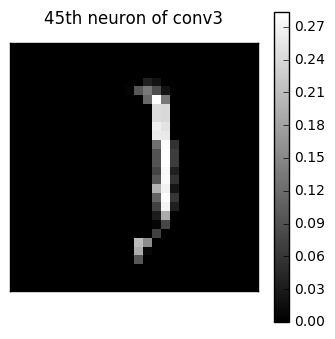

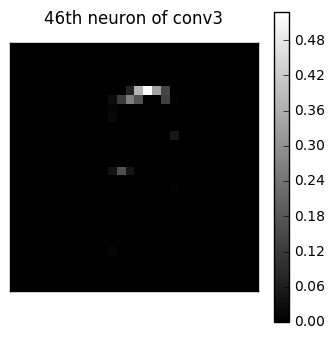

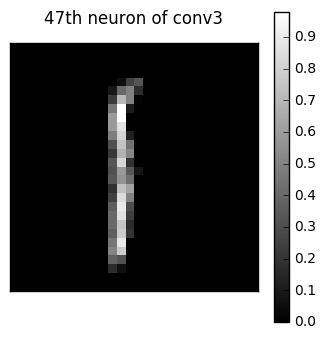

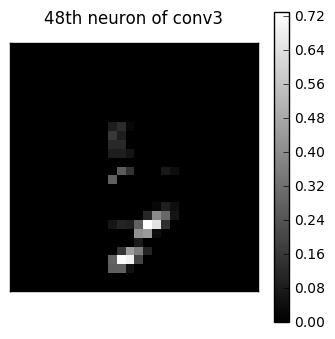

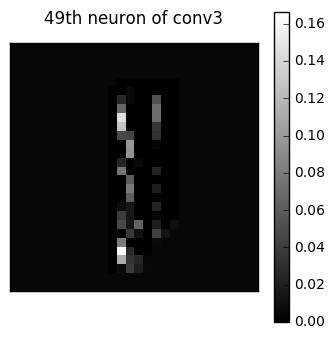

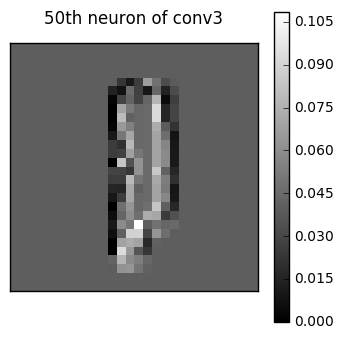

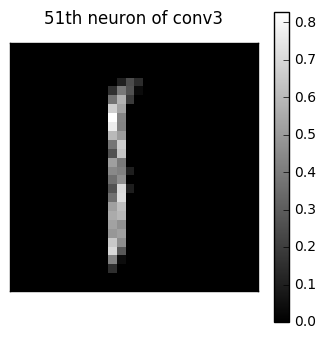

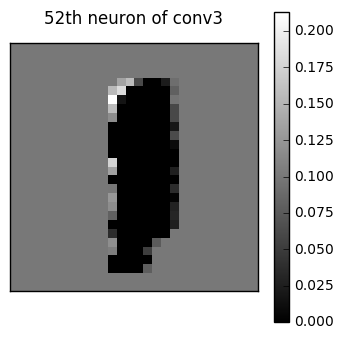

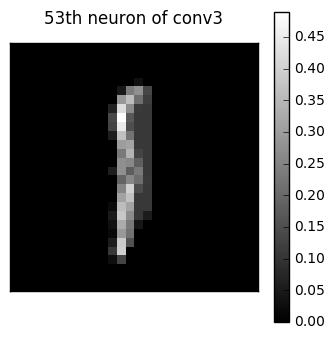

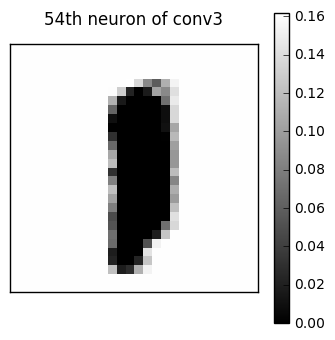

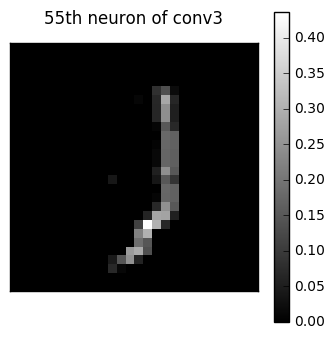

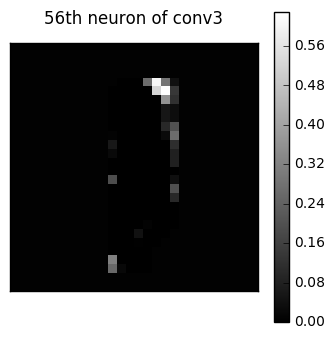

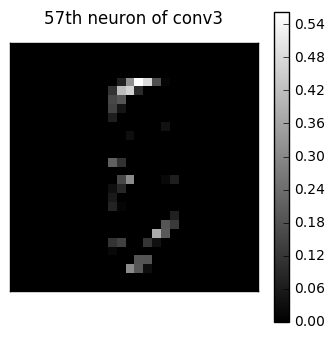

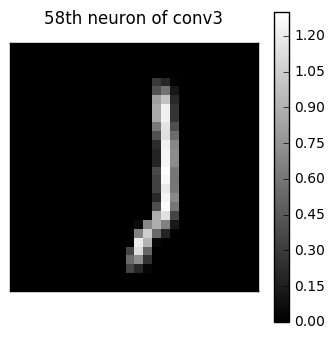

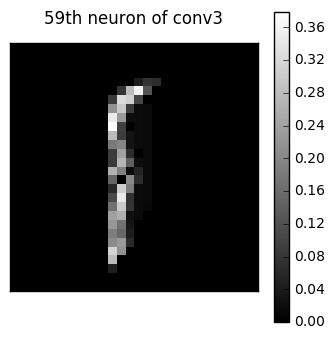

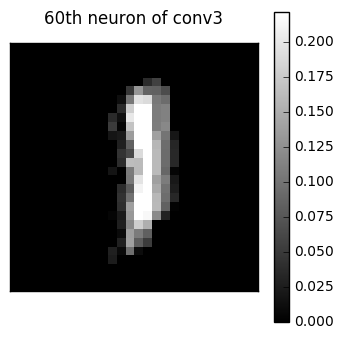

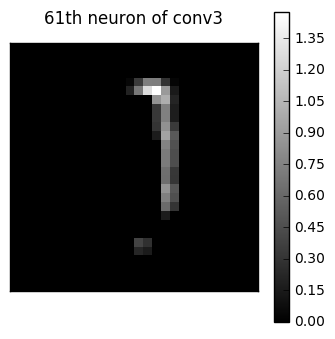

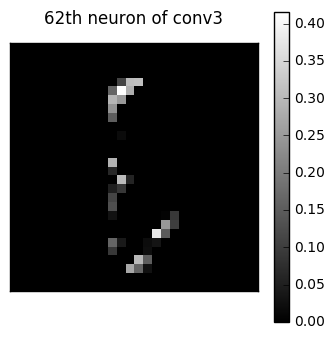

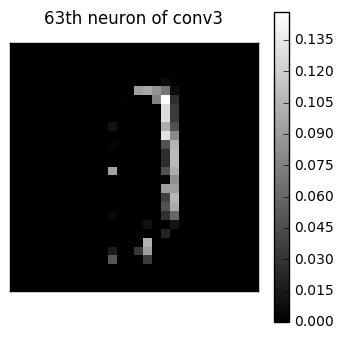

In [40]:
print('Size of conv3 is', conv3.shape)

for i in range(conv3.shape[3]):
    plt.matshow(conv3[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th neuron of conv3")
    plt.colorbar()
    plt.xticks(())
    plt.yticks(())

# Maxpool

Size of maxpool is (1, 14, 14, 64)


C:\Users\StrikeWade\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


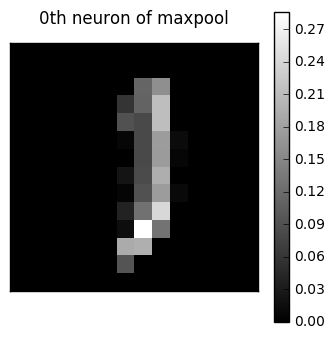

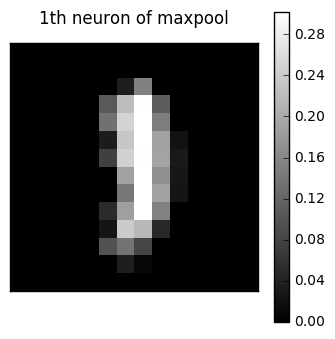

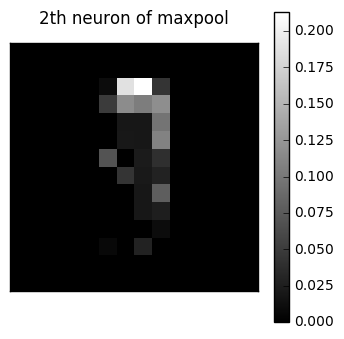

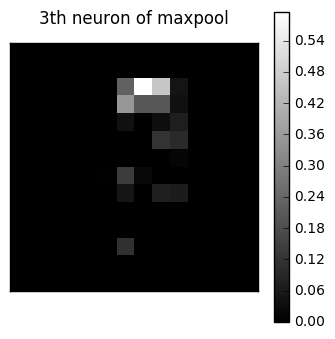

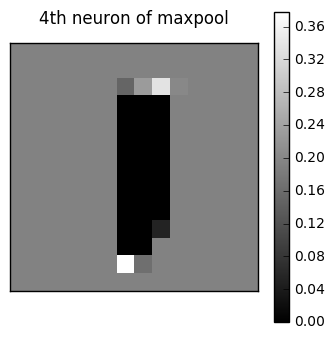

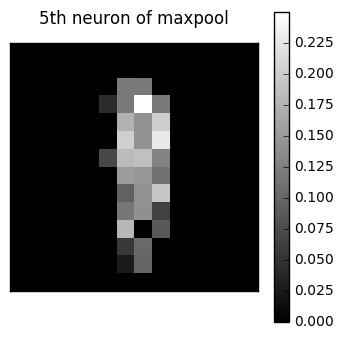

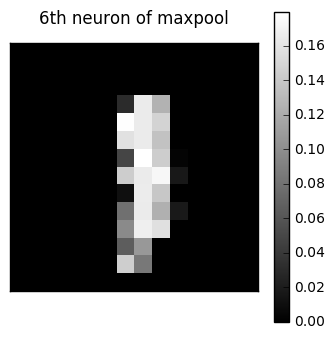

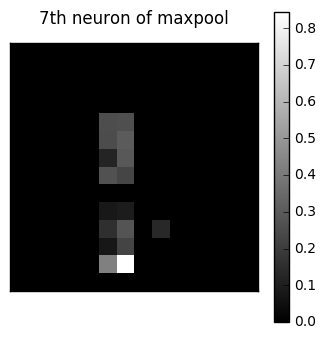

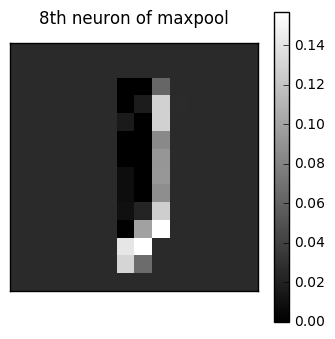

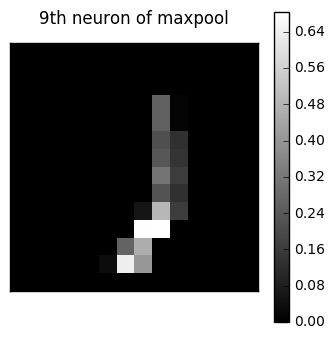

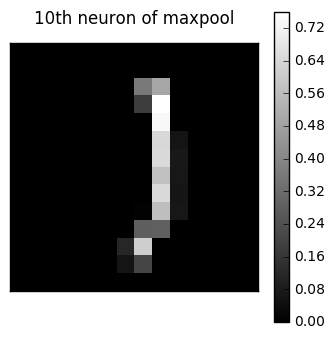

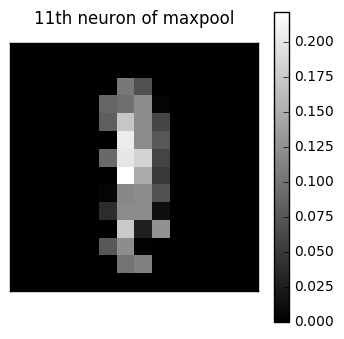

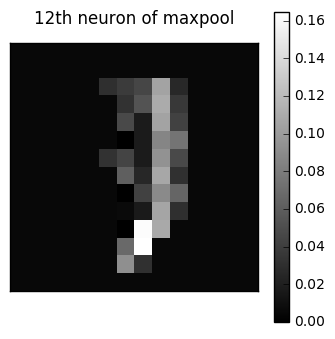

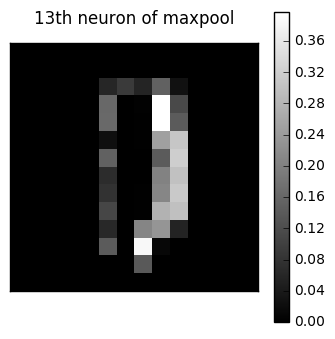

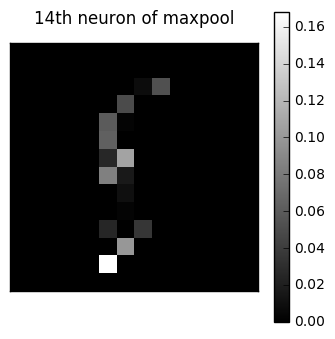

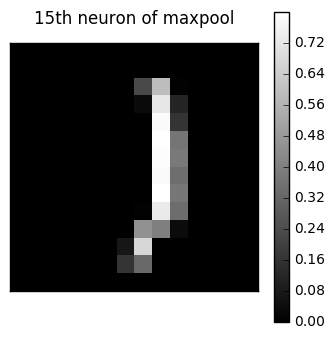

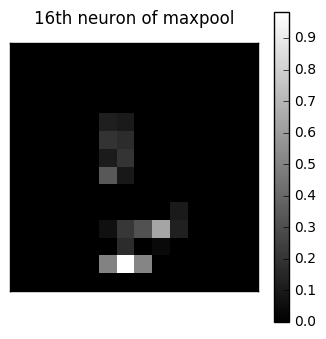

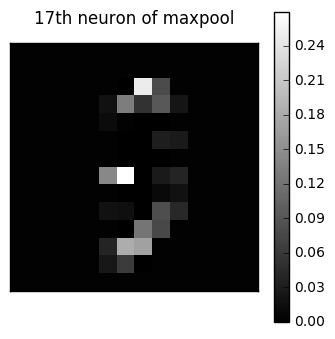

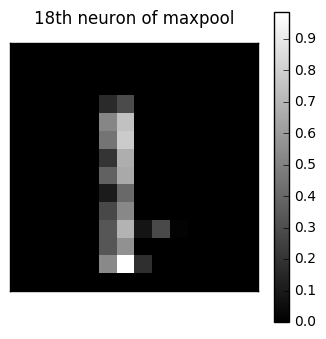

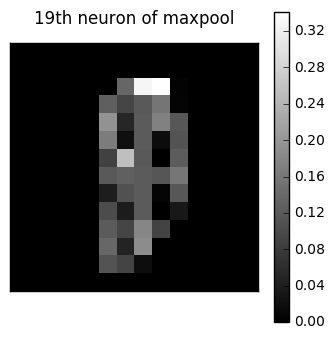

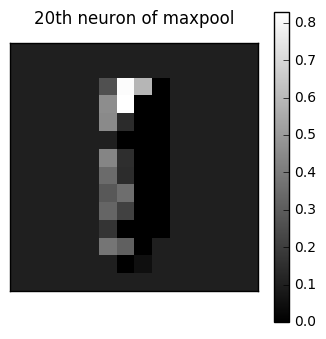

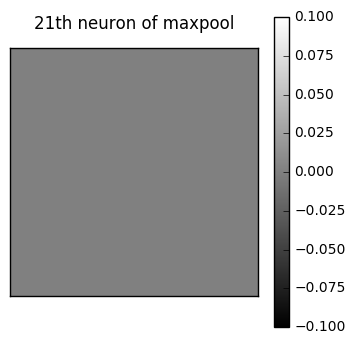

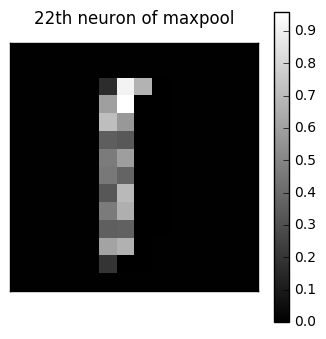

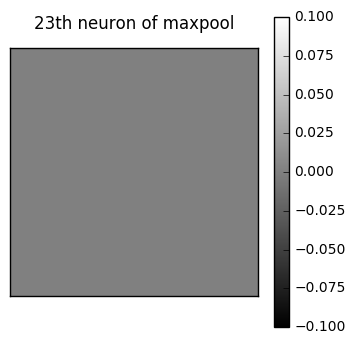

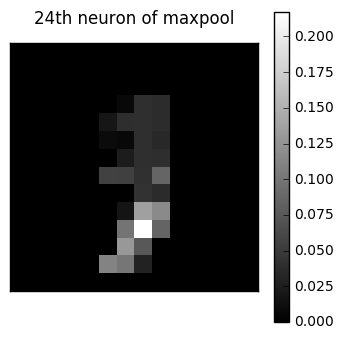

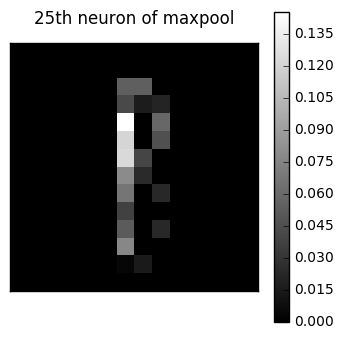

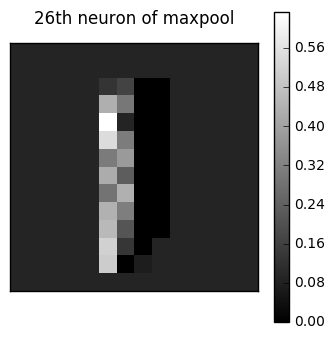

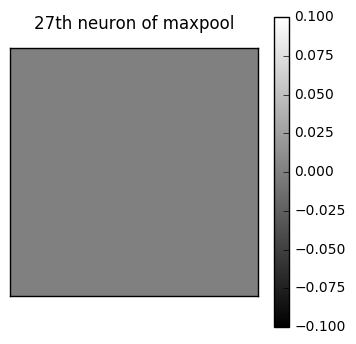

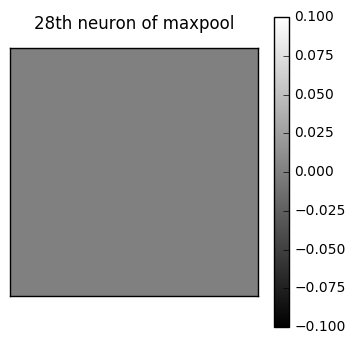

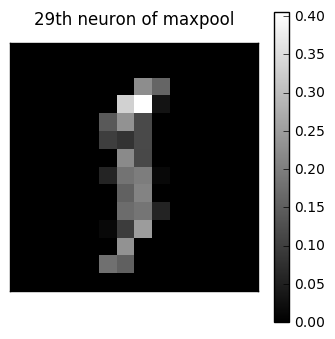

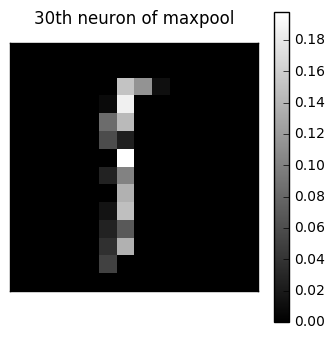

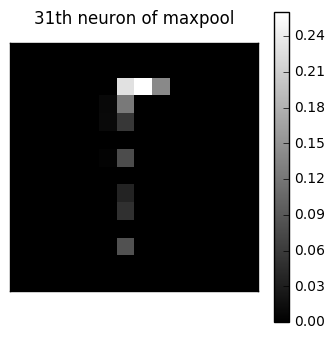

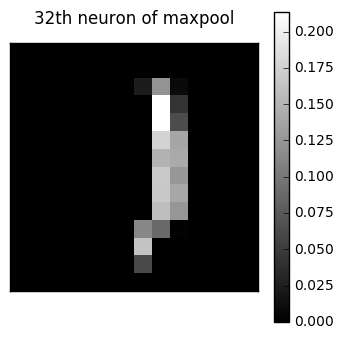

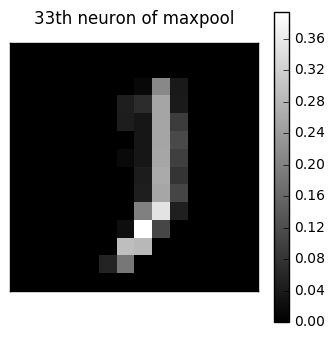

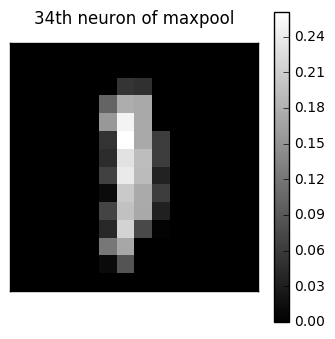

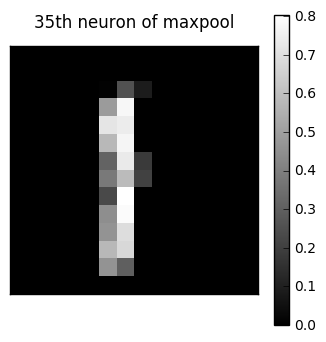

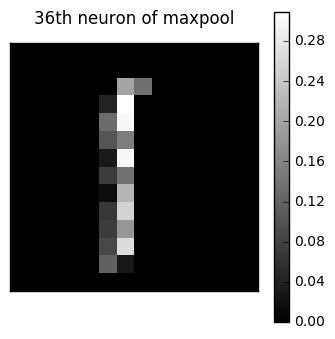

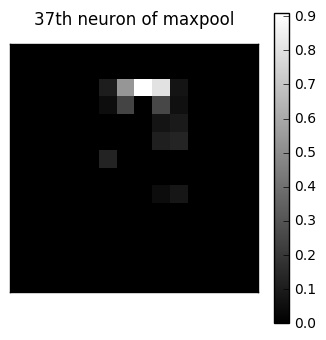

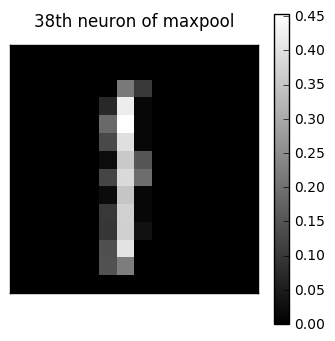

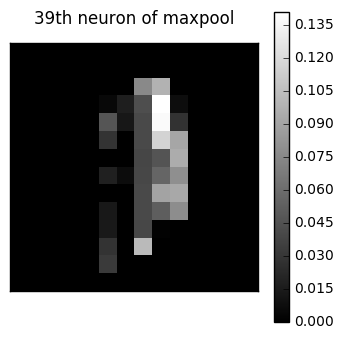

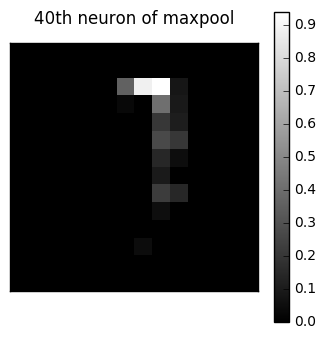

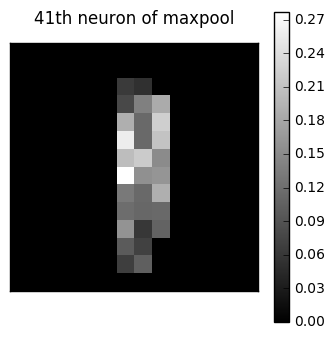

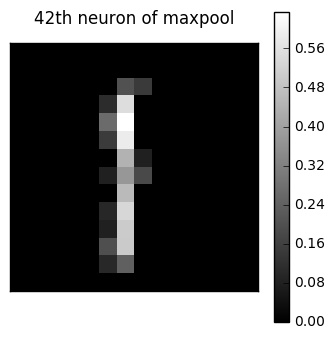

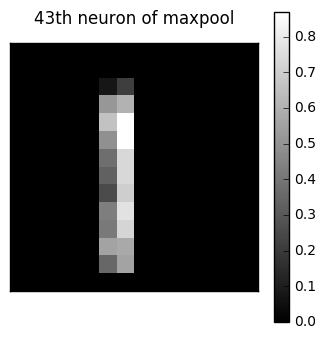

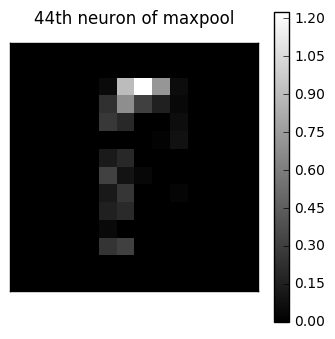

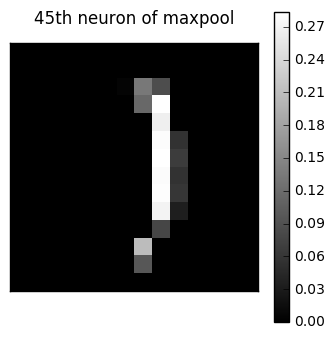

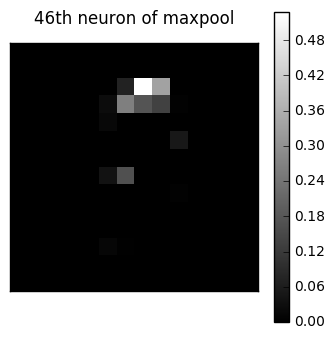

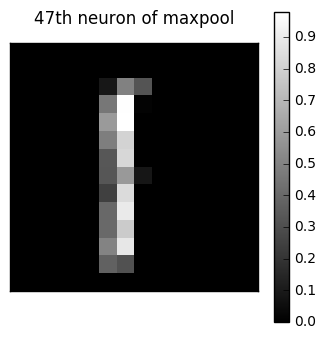

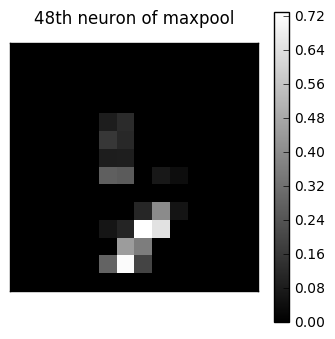

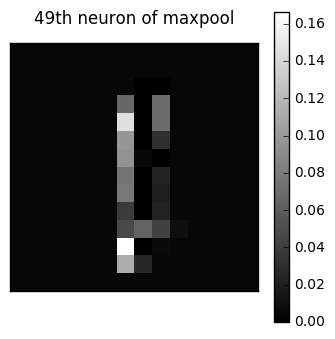

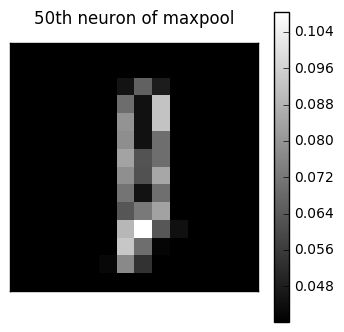

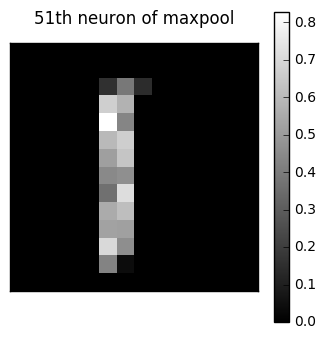

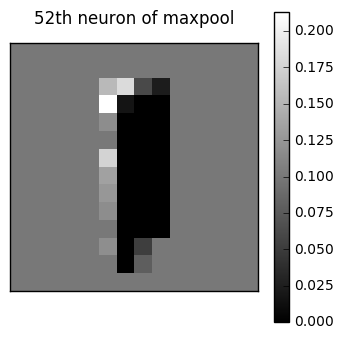

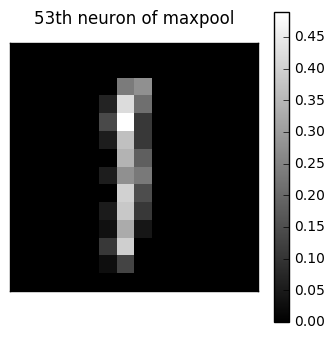

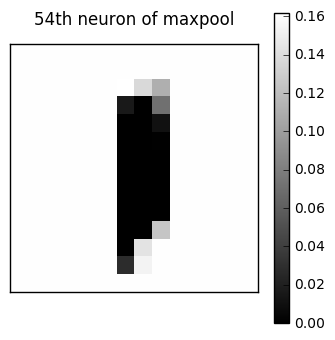

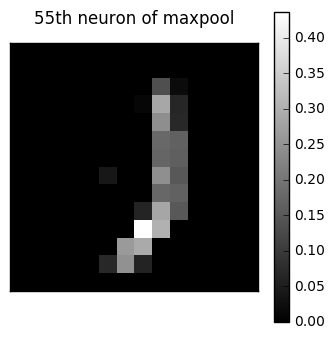

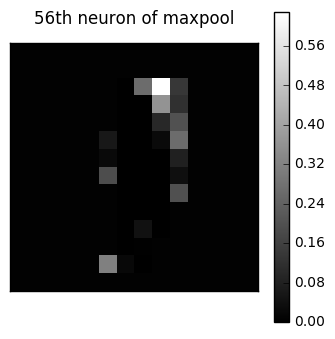

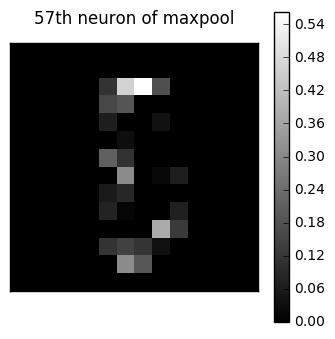

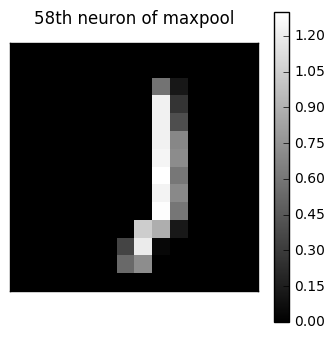

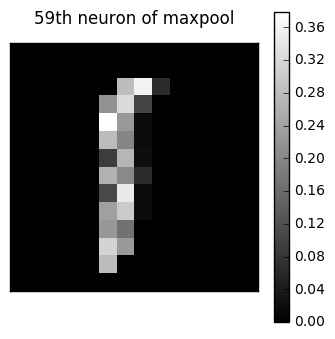

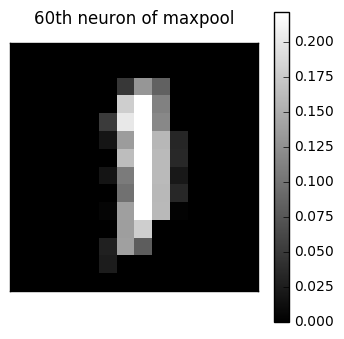

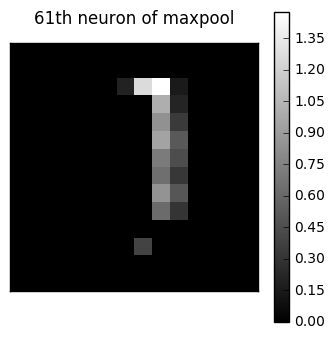

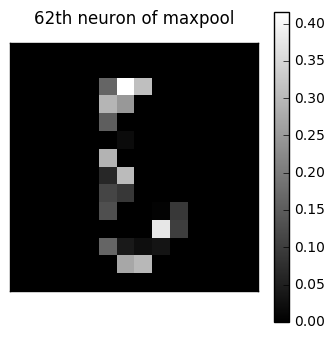

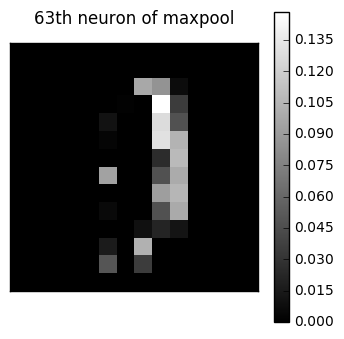

In [42]:
print('Size of maxpool is', maxpool.shape)

for i in range(maxpool.shape[3]):
    plt.matshow(maxpool[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th neuron of maxpool")
    plt.colorbar()
    plt.xticks(())
    plt.yticks(())

In [44]:
print('Size of dense is', dense.shape)
print('Size of out is', out.shape)

Size of dense is (1, 12544)
Size of out is (1, 10)


# Convolution filters (weights)

Size of weight w1 is (3, 3, 1, 64)


C:\Users\StrikeWade\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


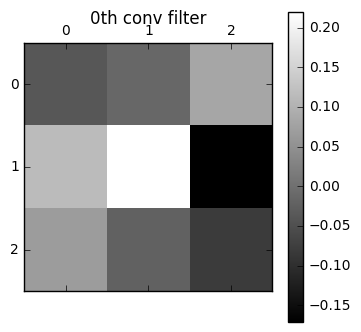

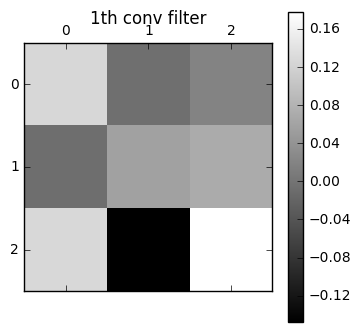

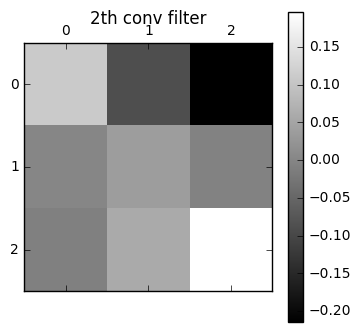

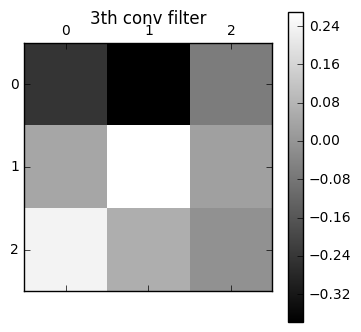

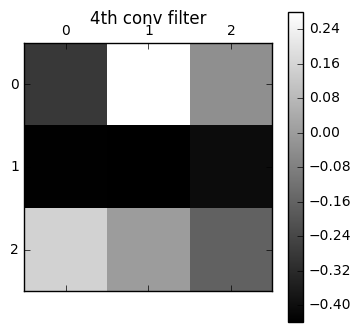

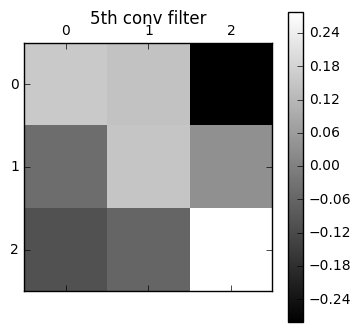

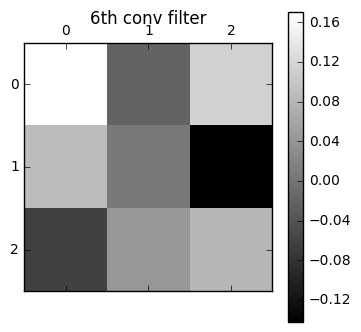

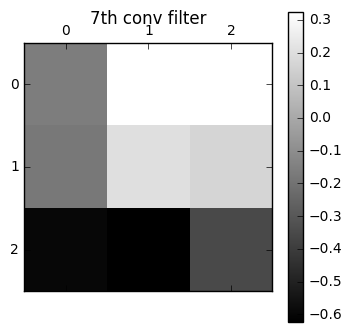

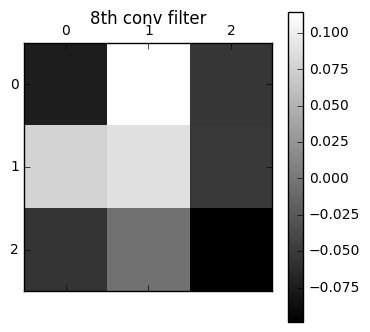

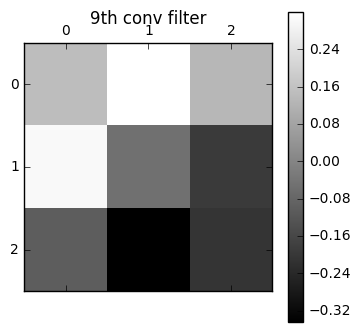

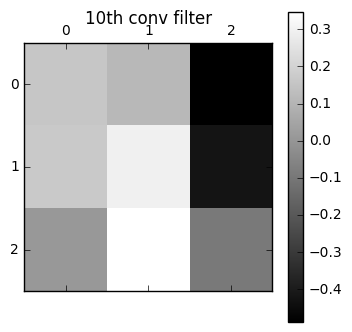

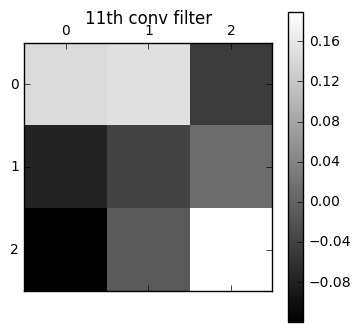

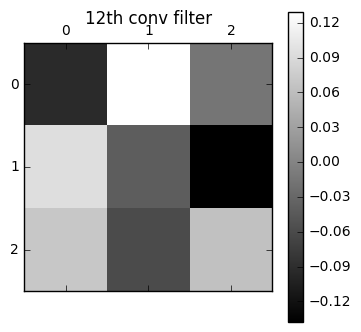

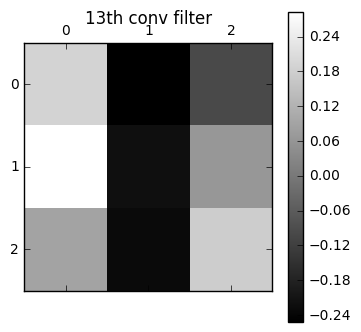

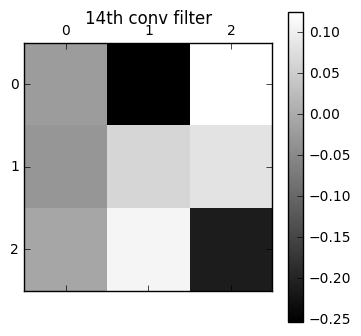

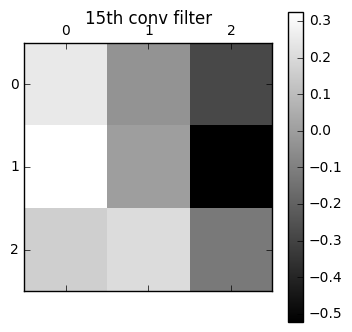

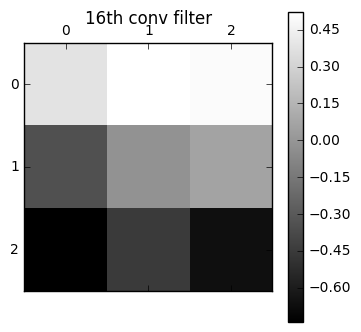

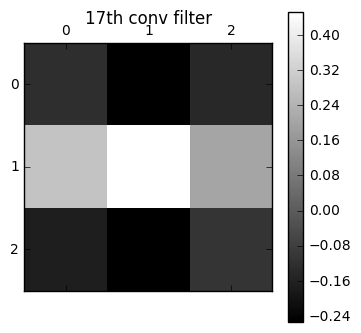

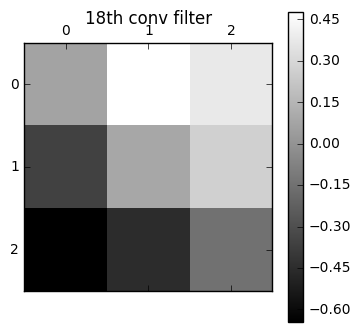

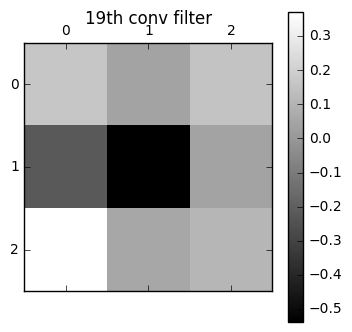

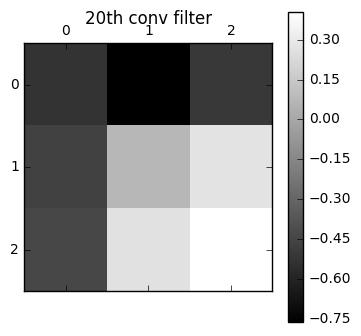

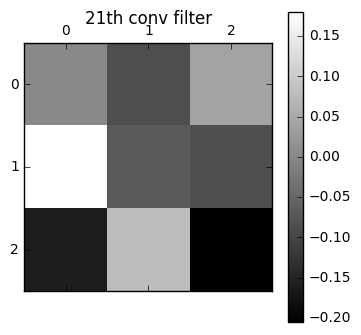

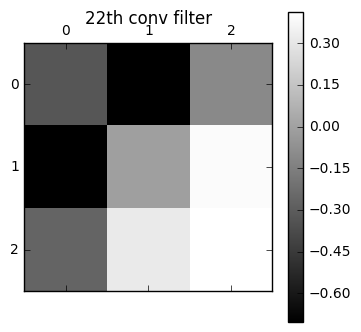

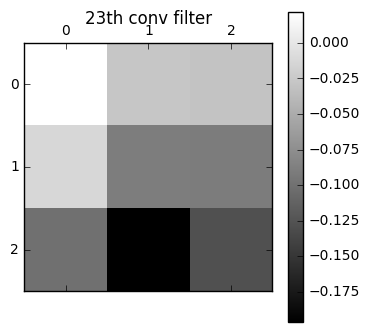

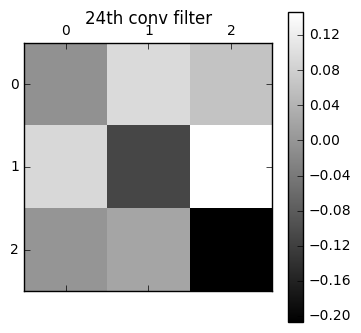

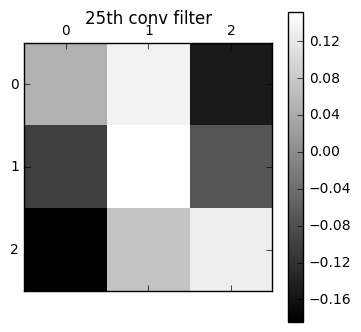

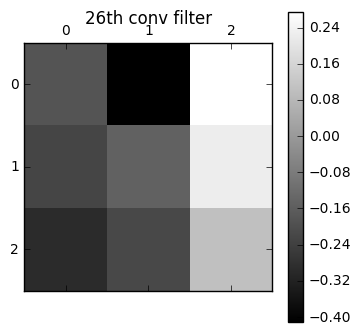

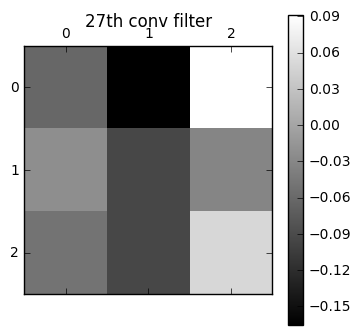

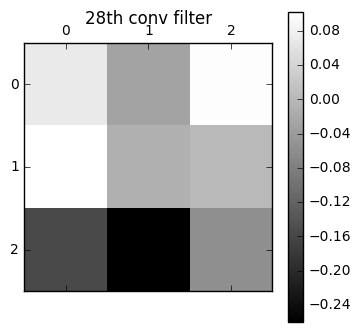

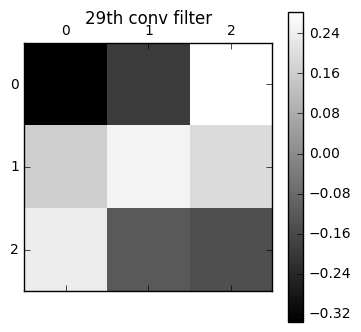

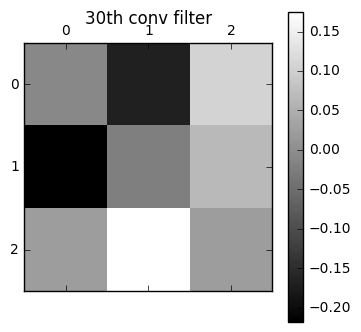

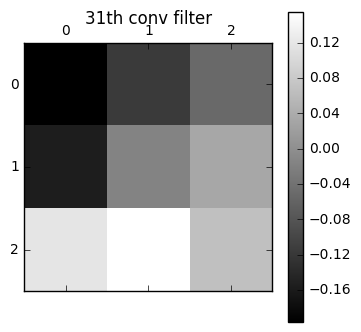

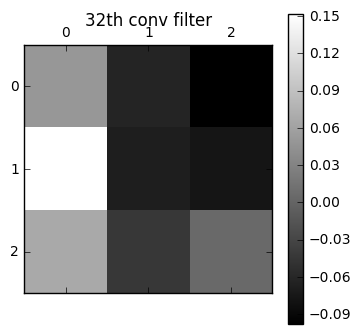

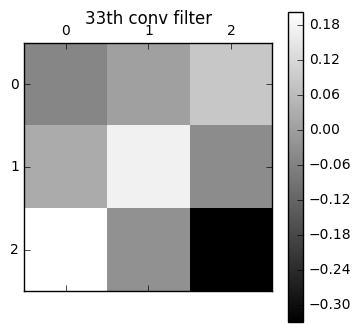

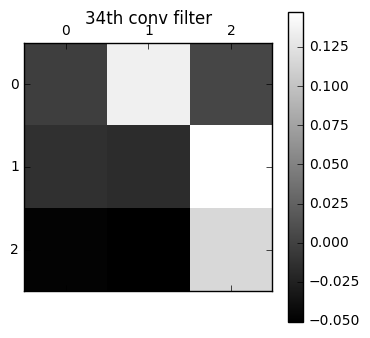

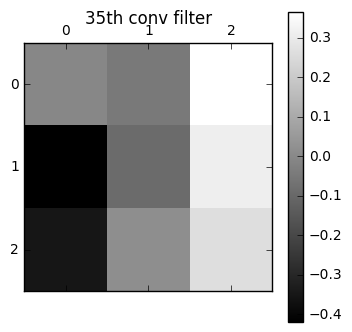

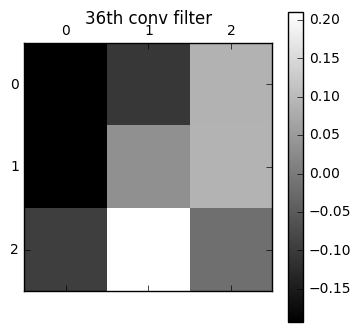

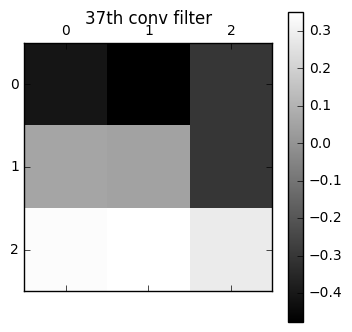

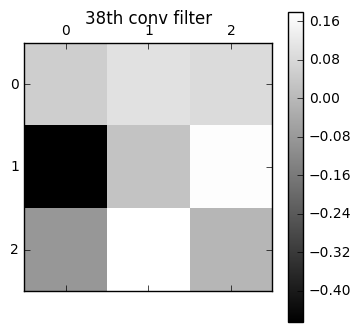

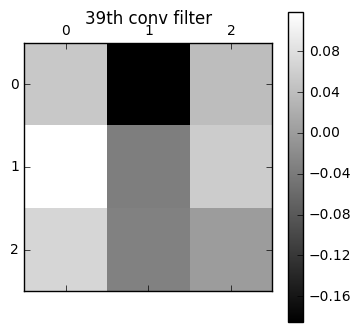

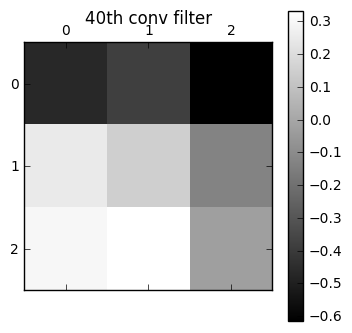

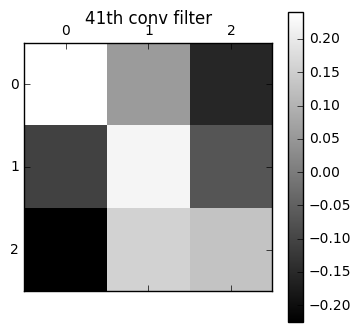

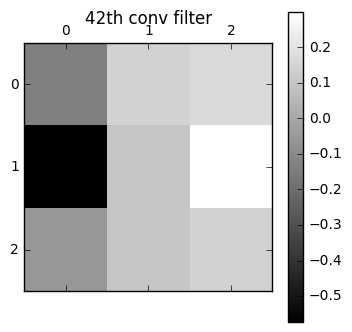

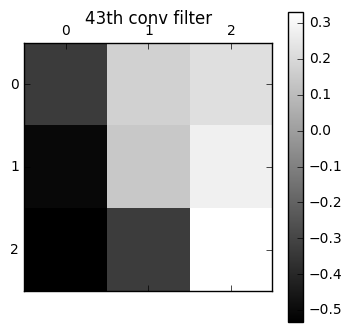

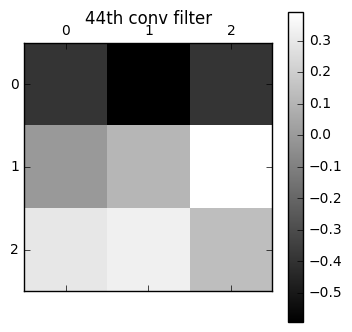

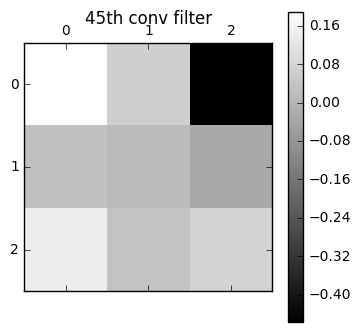

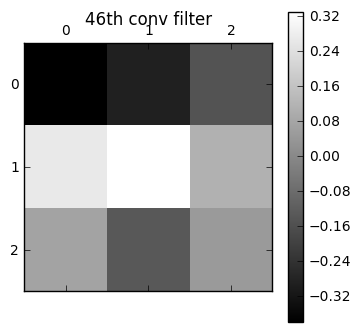

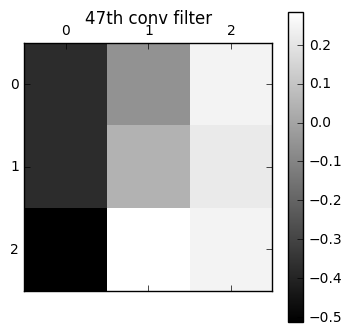

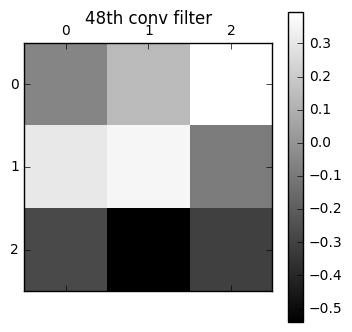

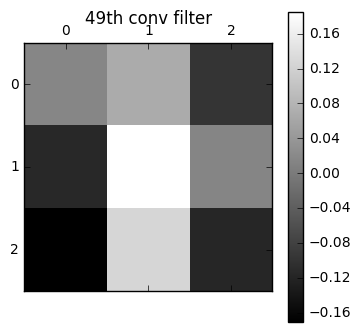

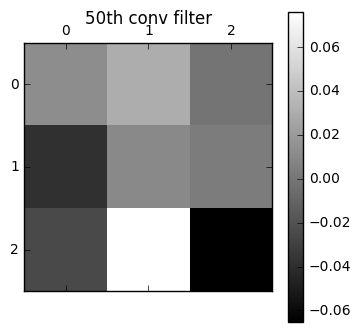

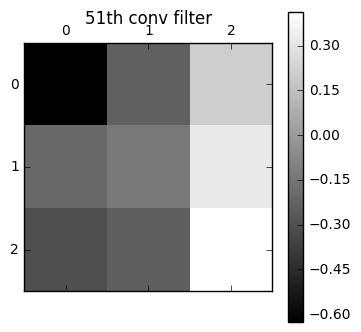

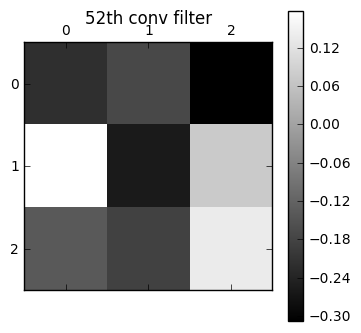

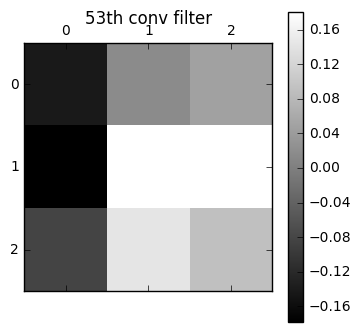

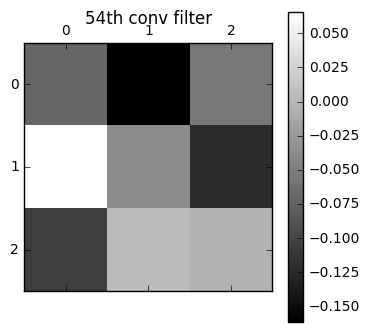

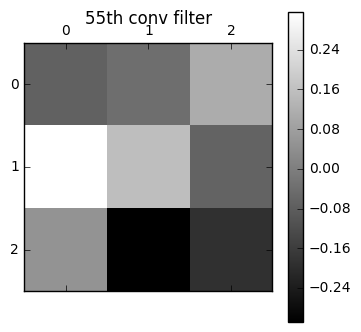

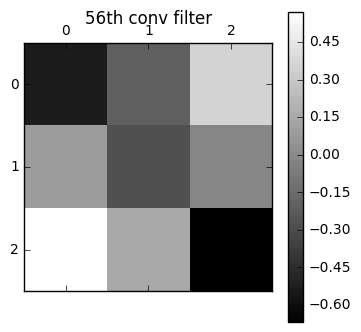

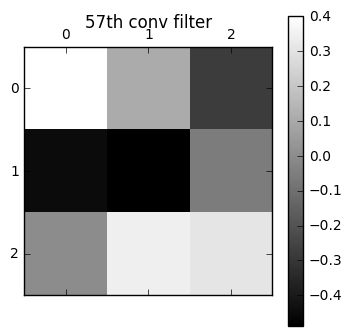

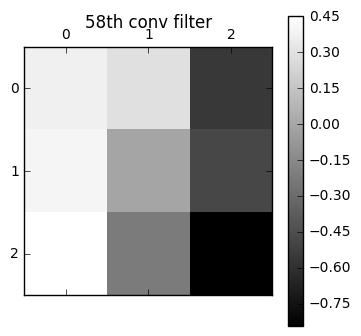

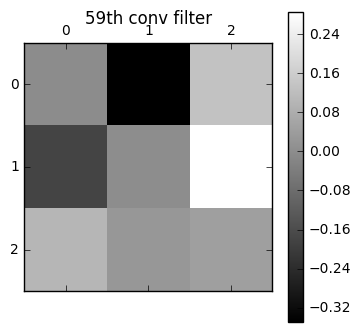

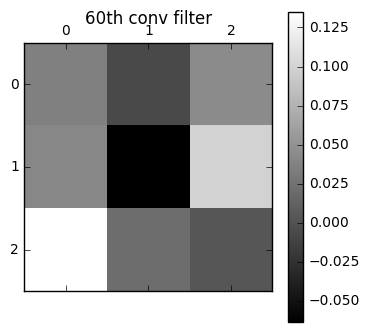

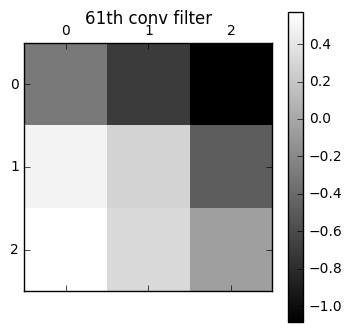

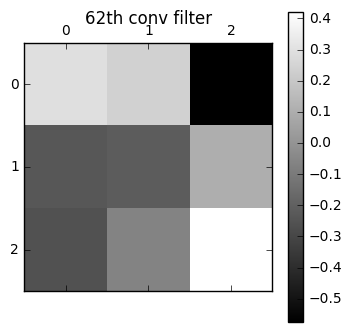

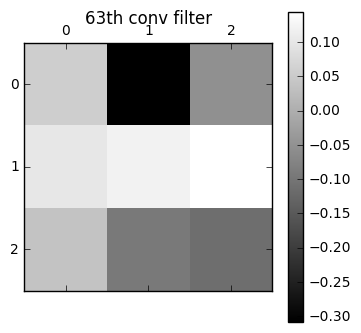

In [48]:
w1 = sess.run(weights['w1'])
print('Size of weight w1 is', w1.shape)

#Plot
for i in range(w1.shape[3]):
    plt.matshow(w1[:, :, 0, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv filter")
    plt.colorbar()
#     plt.xticks(())
#     plt.yticks(())